In [1]:
%cd ..
%ls

C:\Users\Dongmin Kim\Documents\OnlineTSAD
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD 디렉터리

2023-05-04  오후 01:10    <DIR>          .
2023-05-04  오후 01:10    <DIR>          ..
2023-04-10  오후 01:01               156 .gitignore
2023-05-04  오후 02:20    <DIR>          .idea
2023-04-14  오후 04:53    <DIR>          .ipynb_checkpoints
2023-04-27  오후 09:03    <DIR>          cfgs
2023-05-02  오후 05:06    <DIR>          checkpoints
2023-05-02  오후 08:25    <DIR>          data
2023-05-01  오후 03:55    <DIR>          EDA
2023-05-04  오후 01:11    <DIR>          Exp
2023-05-04  오후 02:24    <DIR>          figures
2023-04-09  오후 02:54    <DIR>          hptune
2023-05-02  오후 05:06    <DIR>          logs
2023-05-04  오후 12:54    <DIR>          models
2023-04-26  오후 09:18    <DIR>          outputs
2023-05-02  오후 05:06    <DIR>          plots
2023-05-04  오후 12:22    <DIR>          results
2023-05-04  오후 01:03             3,983 test.py
2023-05-02  오후 04:13    <DIR>    

In [2]:
import numpy as np
import matplotlib as mat
from matplotlib import font_manager, rc

def setPlotStyle():    
    #mat.rcParams['font.family'] = "serif"
    #mat.rcParams['font.serif'] = ["Arial"]
    mat.rcParams['font.family'] = "sans-serif"
    mat.rcParams['font.sans-serif'] = "Times new roman"
    mat.rcParams["axes.titlesize"] = "x-large"
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500
#setPlotStyle()

In [11]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [12]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'SlowRevIN'
cfg["gamma"] = 0.99
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-04 14:25:49,836] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'None', 'tau_beta': 0.99, 'qStart': 0.9, 'qEnd': 1.0, 'qStep': 0.01, 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-04 14:25:49,837] Preparing SWaT dataset...
[202

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'None', 'tau_beta': 0.99, 'qStart': 0.9, 'qEnd': 1.0, 'qStep': 0.01, 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-04 14:25:57,169] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-04 14:25:57,247] Complete.
[2023-05-04 14:25:57,248] Preparing dataloader...
[2023-05-04 14:25:57,830] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-04 14:25:57,832] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-04 14:25:57,832] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

In [13]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
data_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


In [14]:
cols = list(data_df.columns)

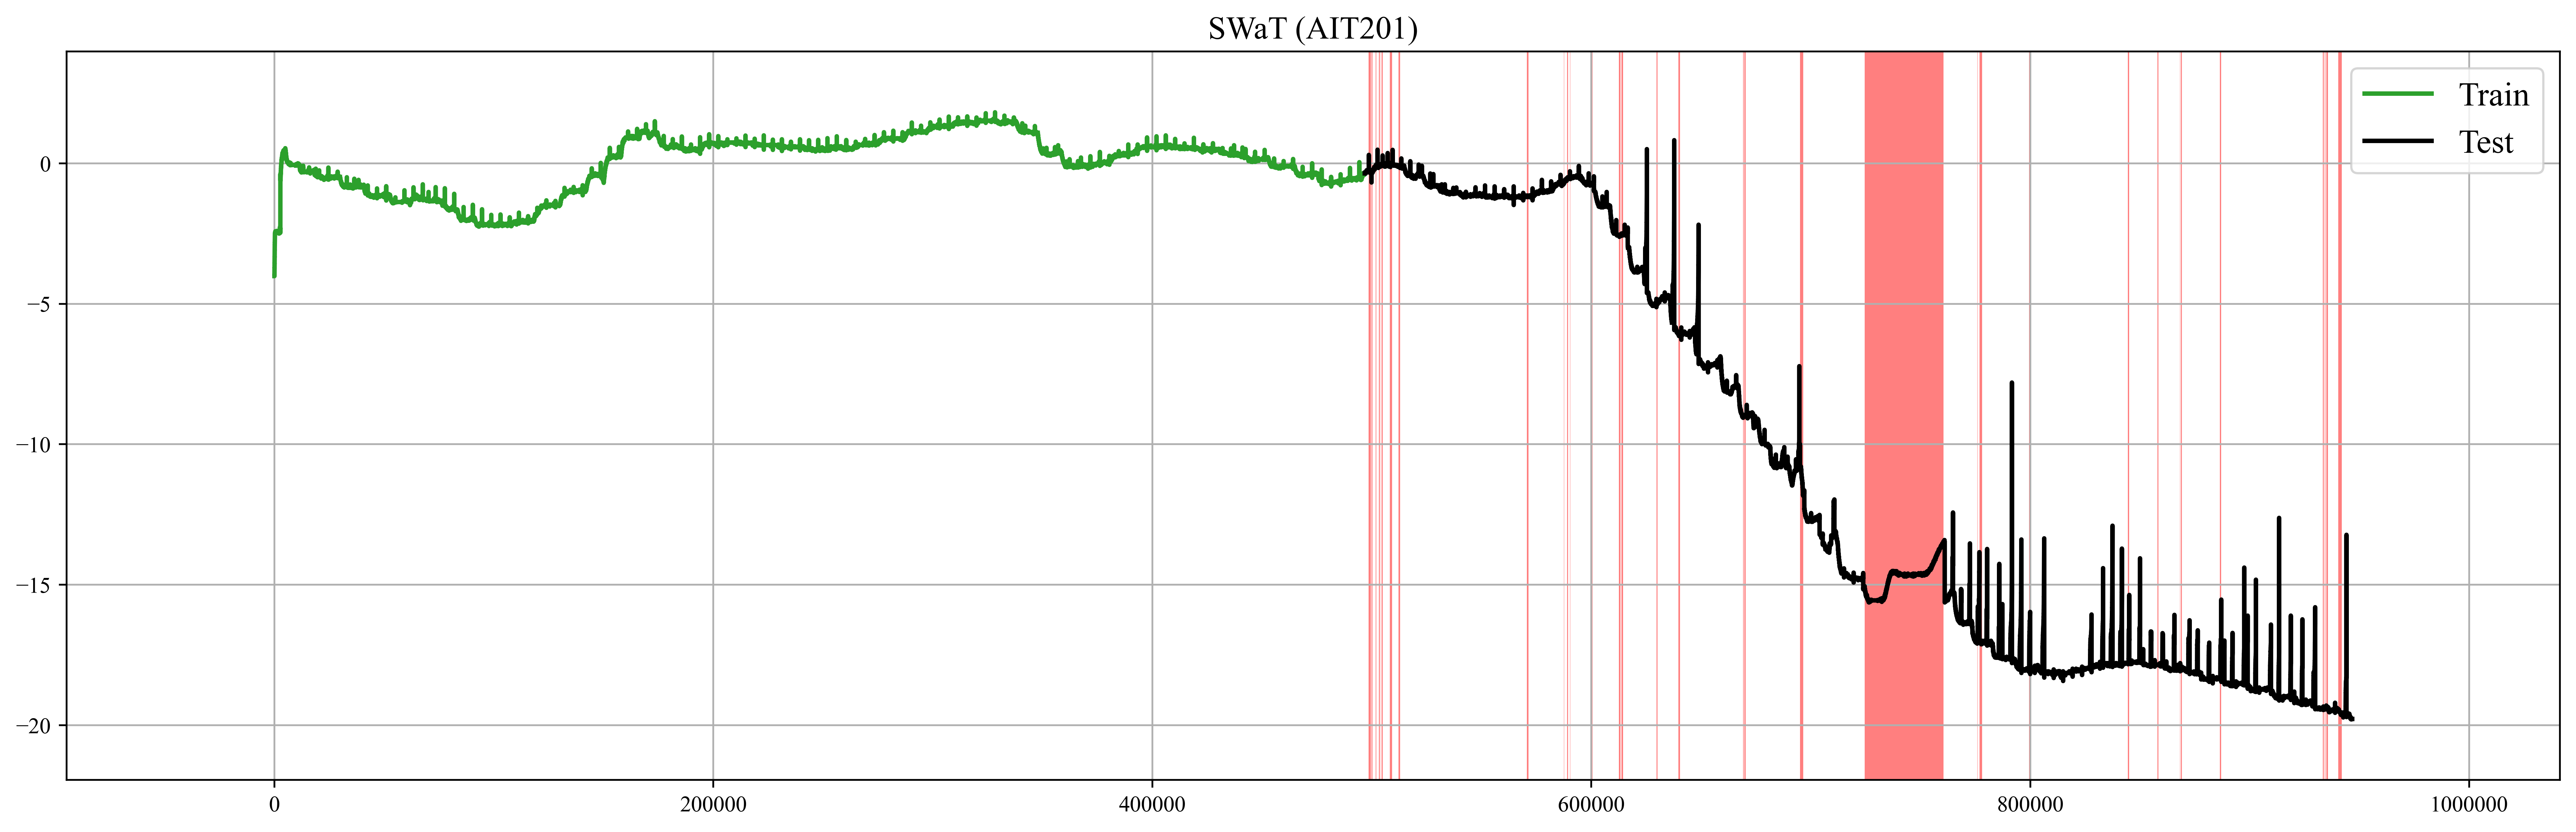

In [15]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)
#plt.title(f"{dataset_name} ({cols[c]})")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")
plt.show()

## PCA plots

In [19]:
from scipy.stats import gaussian_kde, entropy
from sklearn.decomposition import PCA
!pip install universal-divergence
from sklearn.neighbors import NearestNeighbors

In [81]:
def plot_pcavar_return_entropy(train_X, train_y, test_X, test_y):
    print("finding PCA...")
    T, C = train_X.shape
    
    # filter anomalies
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    mask = (1-test_y).astype(bool)
    test_X = test_X[mask]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    data = np.concatenate([train_X, test_X])
    print(data.shape)
    
    if C < 2:
        Xpca_train = train_X
        Xpca_test = test_X
    else:
        x = range(1, min(C, 31))
        d = -1
        evar = []
        for n in x:
            pca = PCA(n_components=n)
            Xpca = pca.fit_transform(data)
            evar.append(sum(pca.explained_variance_ratio_))
            if d == -1 and sum(pca.explained_variance_ratio_) > 0.99 :
                d = n
        print("Done!")
        plt.plot(x, evar)
        plt.axvline(d)
        plt.show()
    
        # kde of PCA'ed outputs.
        pca = PCA(n_components=d) 
        pca_data = pca.fit_transform(data)
        Xpca_train = pca_data[:len(train_X)]
        Xpca_test = pca_data[len(train_X):]
    
    print("estimating kld with knn")
    e = estimate(Xpca_test, Xpca_train)
    print("KLD: ", e)
    print("done")
    return e, Xpca_train, Xpca_test

finding PCA...
(496800, 51) (496800,) (449919, 51) (449919,)
(496800, 51) (496800,) (395335, 51) (449919,)
(892135, 51)
Done!


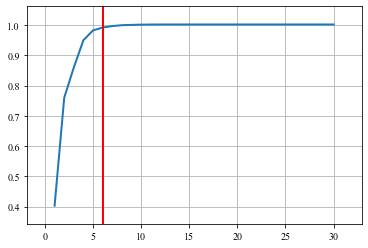

estimating kld with knn


KeyboardInterrupt: 

In [84]:
datasets = ["SWaT", "WADI", "PSM", "CreditCard", "MSL_P-15", "SMD_machine-1-4", "Pump"]
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# PSM
train_X, train_y, test_X, test_y = DataFactory.load_PSM()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# Pump
train_X, train_y, test_X, test_y = DataFactory.load_Pump()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# Basic Bar Chart
plt.bar(datasets, entropies)
plt.title('Entropy of Kernel Density Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Entropy', fontsize=18)
plt.show()

In [43]:
train_KDE = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Xpca_train)
test_KDE = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Xpca_test)

In [47]:
logp = train_KDE.score_samples(Xpca_test)
logq = test_KDE.score_samples(Xpca_test)
q = np.exp(logq)


In [39]:
if True:
    import pdb;pdb.set_trace();
    kldiv(Xpca_test, Xpca_train)

> <ipython-input-39-03ed928a67fc>(3)<module>()
      1 if True:
      2     import pdb;pdb.set_trace();
----> 3     kldiv(Xpca_test, Xpca_train)

ipdb> s
--Call--
> <ipython-input-36-62c341142541>(108)kldiv()
    106 
    107 
--> 108 def kldiv(x, xp, k=3, base=2):
    109     """KL Divergence between p and q for x~p(x), xp~q(x)
    110     x, xp should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]

ipdb> n
> <ipython-input-36-62c341142541>(113)kldiv()
    111     if x is a one-dimensional scalar and we have four samples
    112     """
--> 113     assert k < min(len(x), len(xp)), "Set k smaller than num. samples - 1"
    114     assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    115     x, xp = np.asarray(x), np.asarray(xp)

ipdb> n
> <ipython-input-36-62c341142541>(114)kldiv()
    112     """
    113     assert k < min(len(x), len(xp)), "Set k smaller than num. samples - 1"
--> 114     assert len(x[0]) == len(xp[0]), "Two distributions must have

ipdb> n
> <ipython-input-36-62c341142541>(118)kldiv()
    116     x, xp = x.reshape(x.shape[0], -1), xp.reshape(xp.shape[0], -1)
    117     d = len(x[0])
--> 118     n = len(x)
    119     m = len(xp)
    120     const = log(m) - log(n - 1)

ipdb> n
> <ipython-input-36-62c341142541>(119)kldiv()
    117     d = len(x[0])
    118     n = len(x)
--> 119     m = len(xp)
    120     const = log(m) - log(n - 1)
    121     tree = build_tree(x)

ipdb> n
> <ipython-input-36-62c341142541>(120)kldiv()
    118     n = len(x)
    119     m = len(xp)
--> 120     const = log(m) - log(n - 1)
    121     tree = build_tree(x)
    122     treep = build_tree(xp)

ipdb> n
> <ipython-input-36-62c341142541>(121)kldiv()
    119     m = len(xp)
    120     const = log(m) - log(n - 1)
--> 121     tree = build_tree(x)
    122     treep = build_tree(xp)
    123     nn = query_neighbors(tree, x, k)

ipdb> n
> <ipython-input-36-62c341142541>(122)kldiv()
    120     const = log(m) - log(n - 1)
    121     tree = b

ipdb> tree.query(x, k=k + 1)[0][:, k].shape
(2836,)
ipdb> n
> <ipython-input-36-62c341142541>(279)query_neighbors()
    277 
    278 def query_neighbors(tree, x, k):
--> 279     return tree.query(x, k=k + 1)[0][:, k]
    280 
    281 

ipdb> n
--Return--
array([1.0087...94615043e-01])
> <ipython-input-36-62c341142541>(279)query_neighbors()
    277 
    278 def query_neighbors(tree, x, k):
--> 279     return tree.query(x, k=k + 1)[0][:, k]
    280 
    281 

ipdb> n
> <ipython-input-36-62c341142541>(124)kldiv()
    122     treep = build_tree(xp)
    123     nn = query_neighbors(tree, x, k)
--> 124     nnp = query_neighbors(treep, x, k - 1)
    125     return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)
    126 

ipdb> x.shape
(2836, 16)
ipdb> n
> <ipython-input-36-62c341142541>(125)kldiv()
    123     nn = query_neighbors(tree, x, k)
    124     nnp = query_neighbors(treep, x, k - 1)
--> 125     return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(ba

BdbQuit: 

In [50]:
logp

array([-4.79503923, -4.26902179,  7.44884701, ...,  1.25466446,
       -3.11738347, -5.81432388])

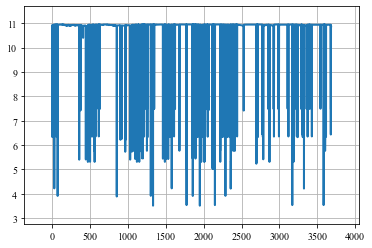

In [35]:
plt.figure(figsize=(20, 6))
plt.scatter(train_KDE.score_samples(Xpca_train))

In [57]:
Xpca_train.shape

(132481, 13)

In [60]:
# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)


finding PCA...
(400, 1) (400,) (1022, 1) (1022,)
(400, 1) (400,) (989, 1) (1022,)
nan


finding PCA...
Done!


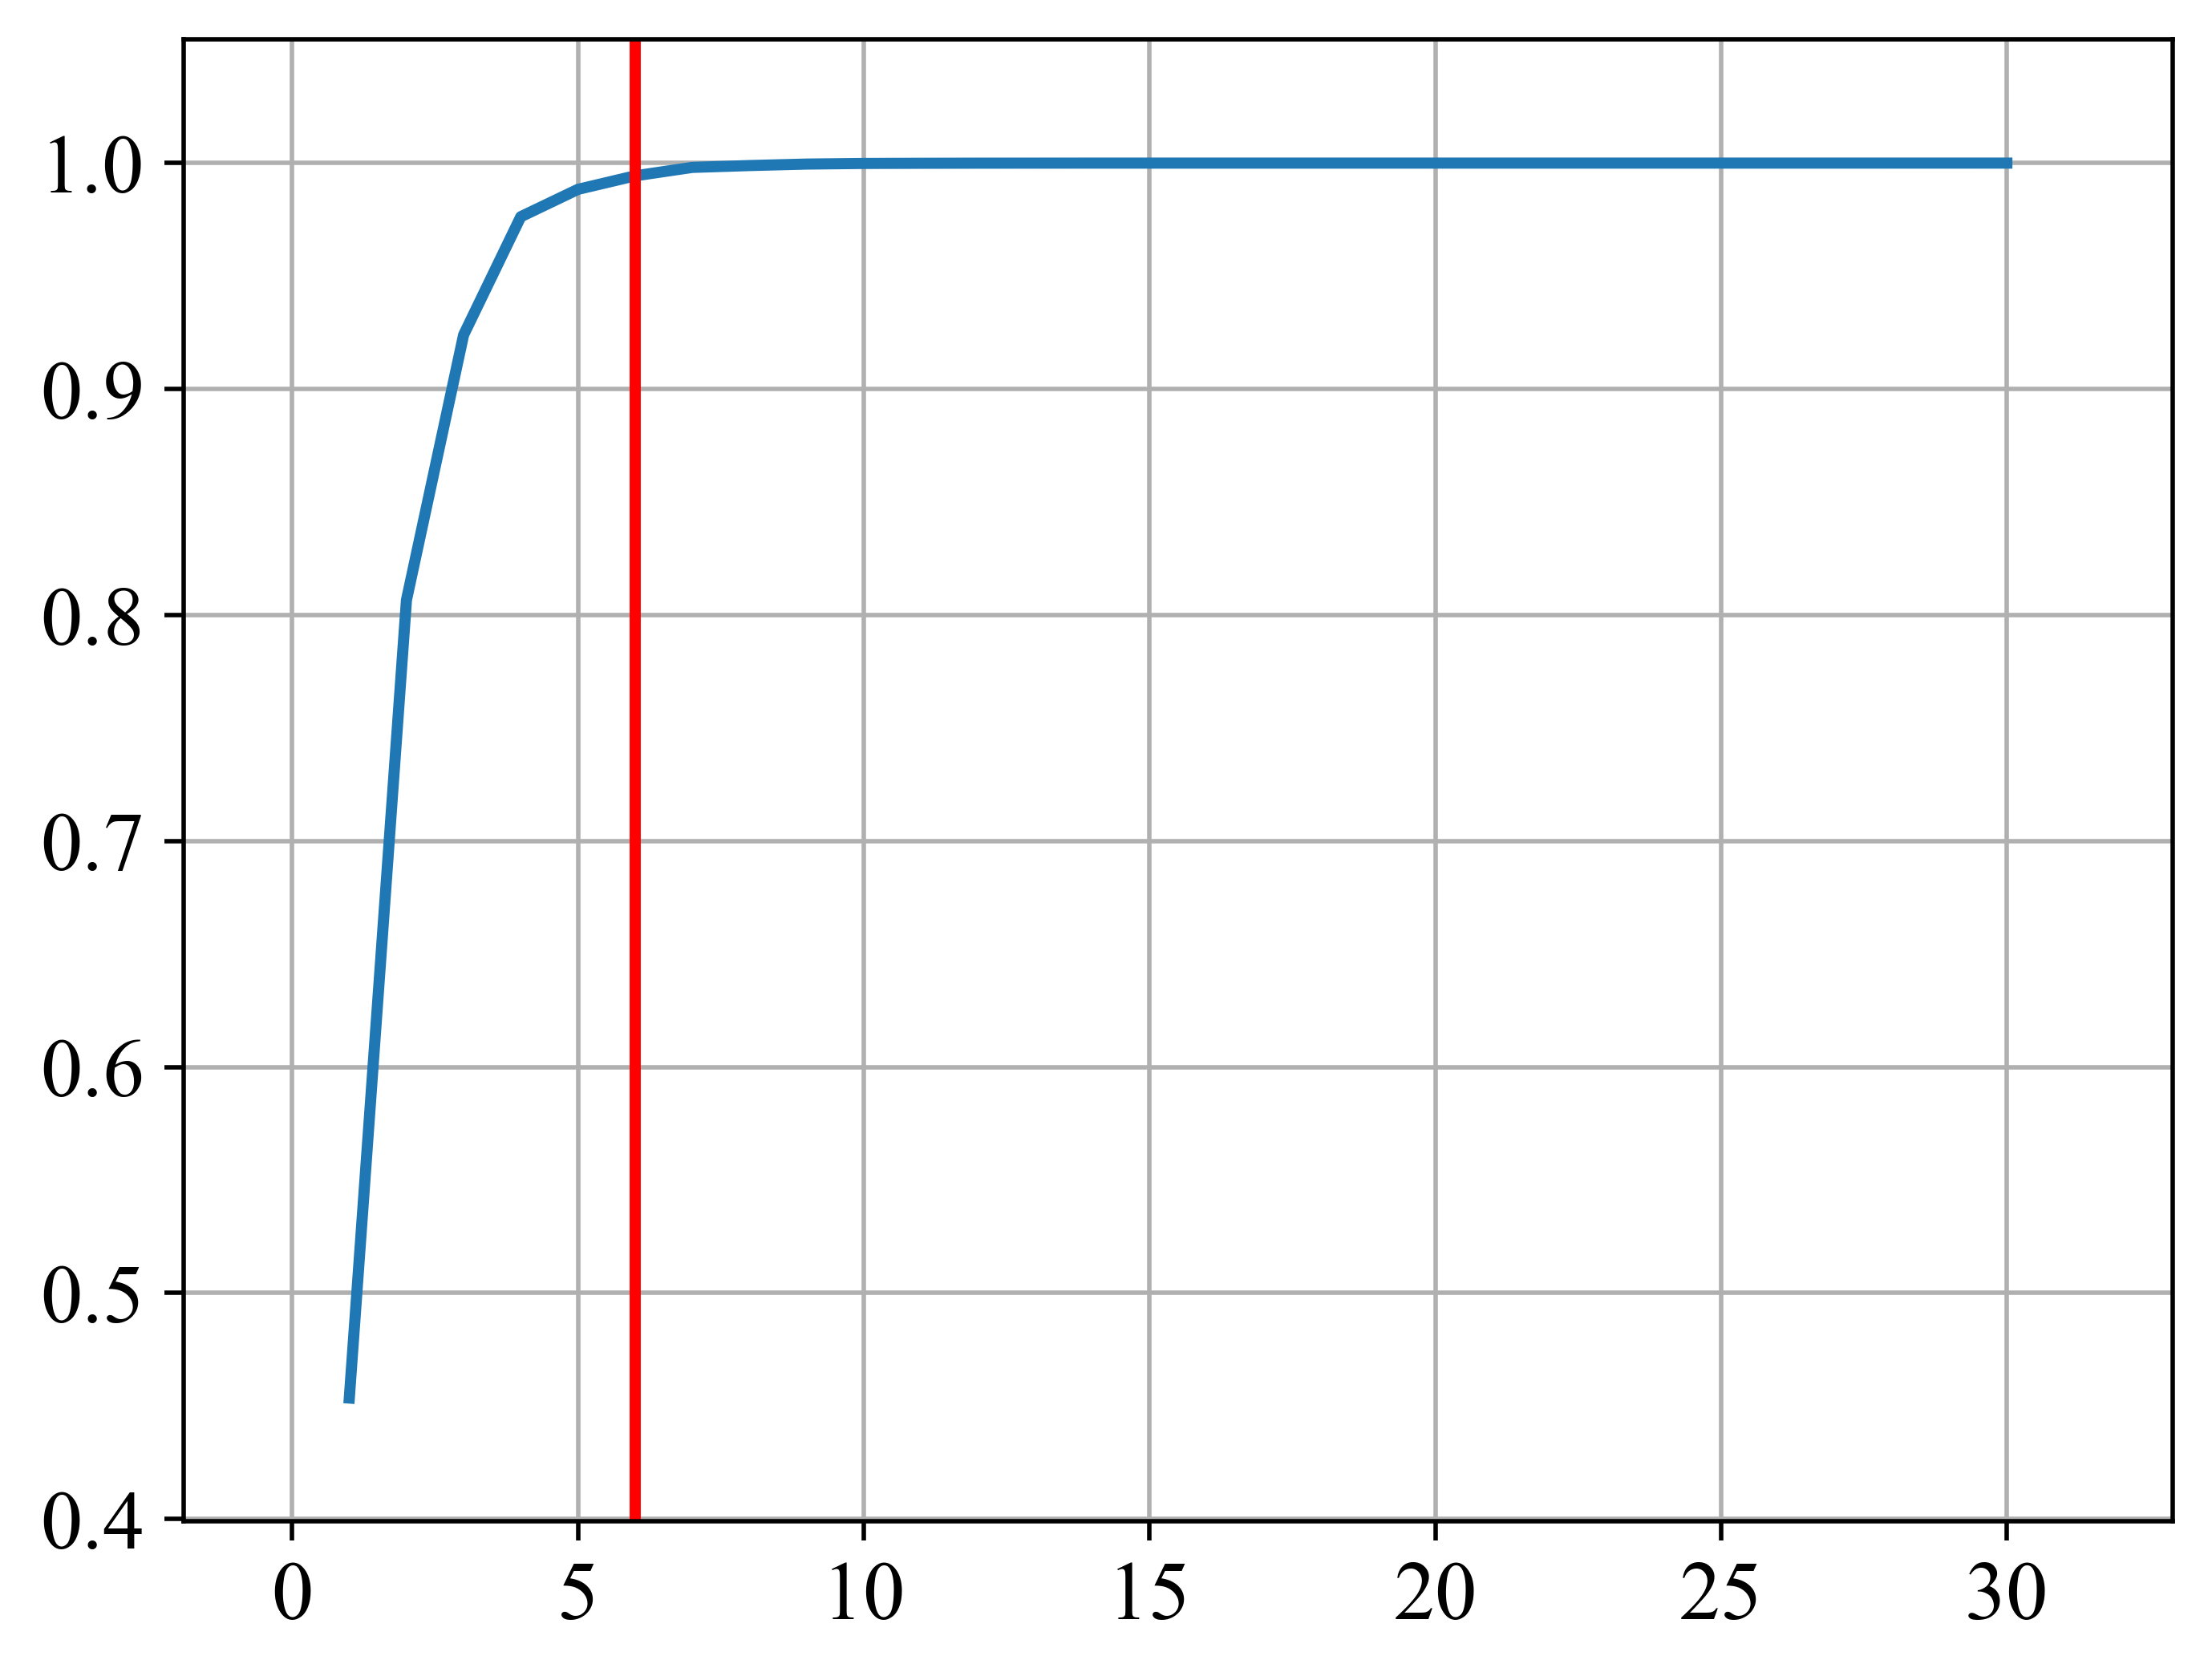

(496800, 51) (496800,) (449919, 51) (449919,)
(496800, 51) (496800,) (395335, 51) (449919,)
38.91240909912191
finding PCA...
Done!


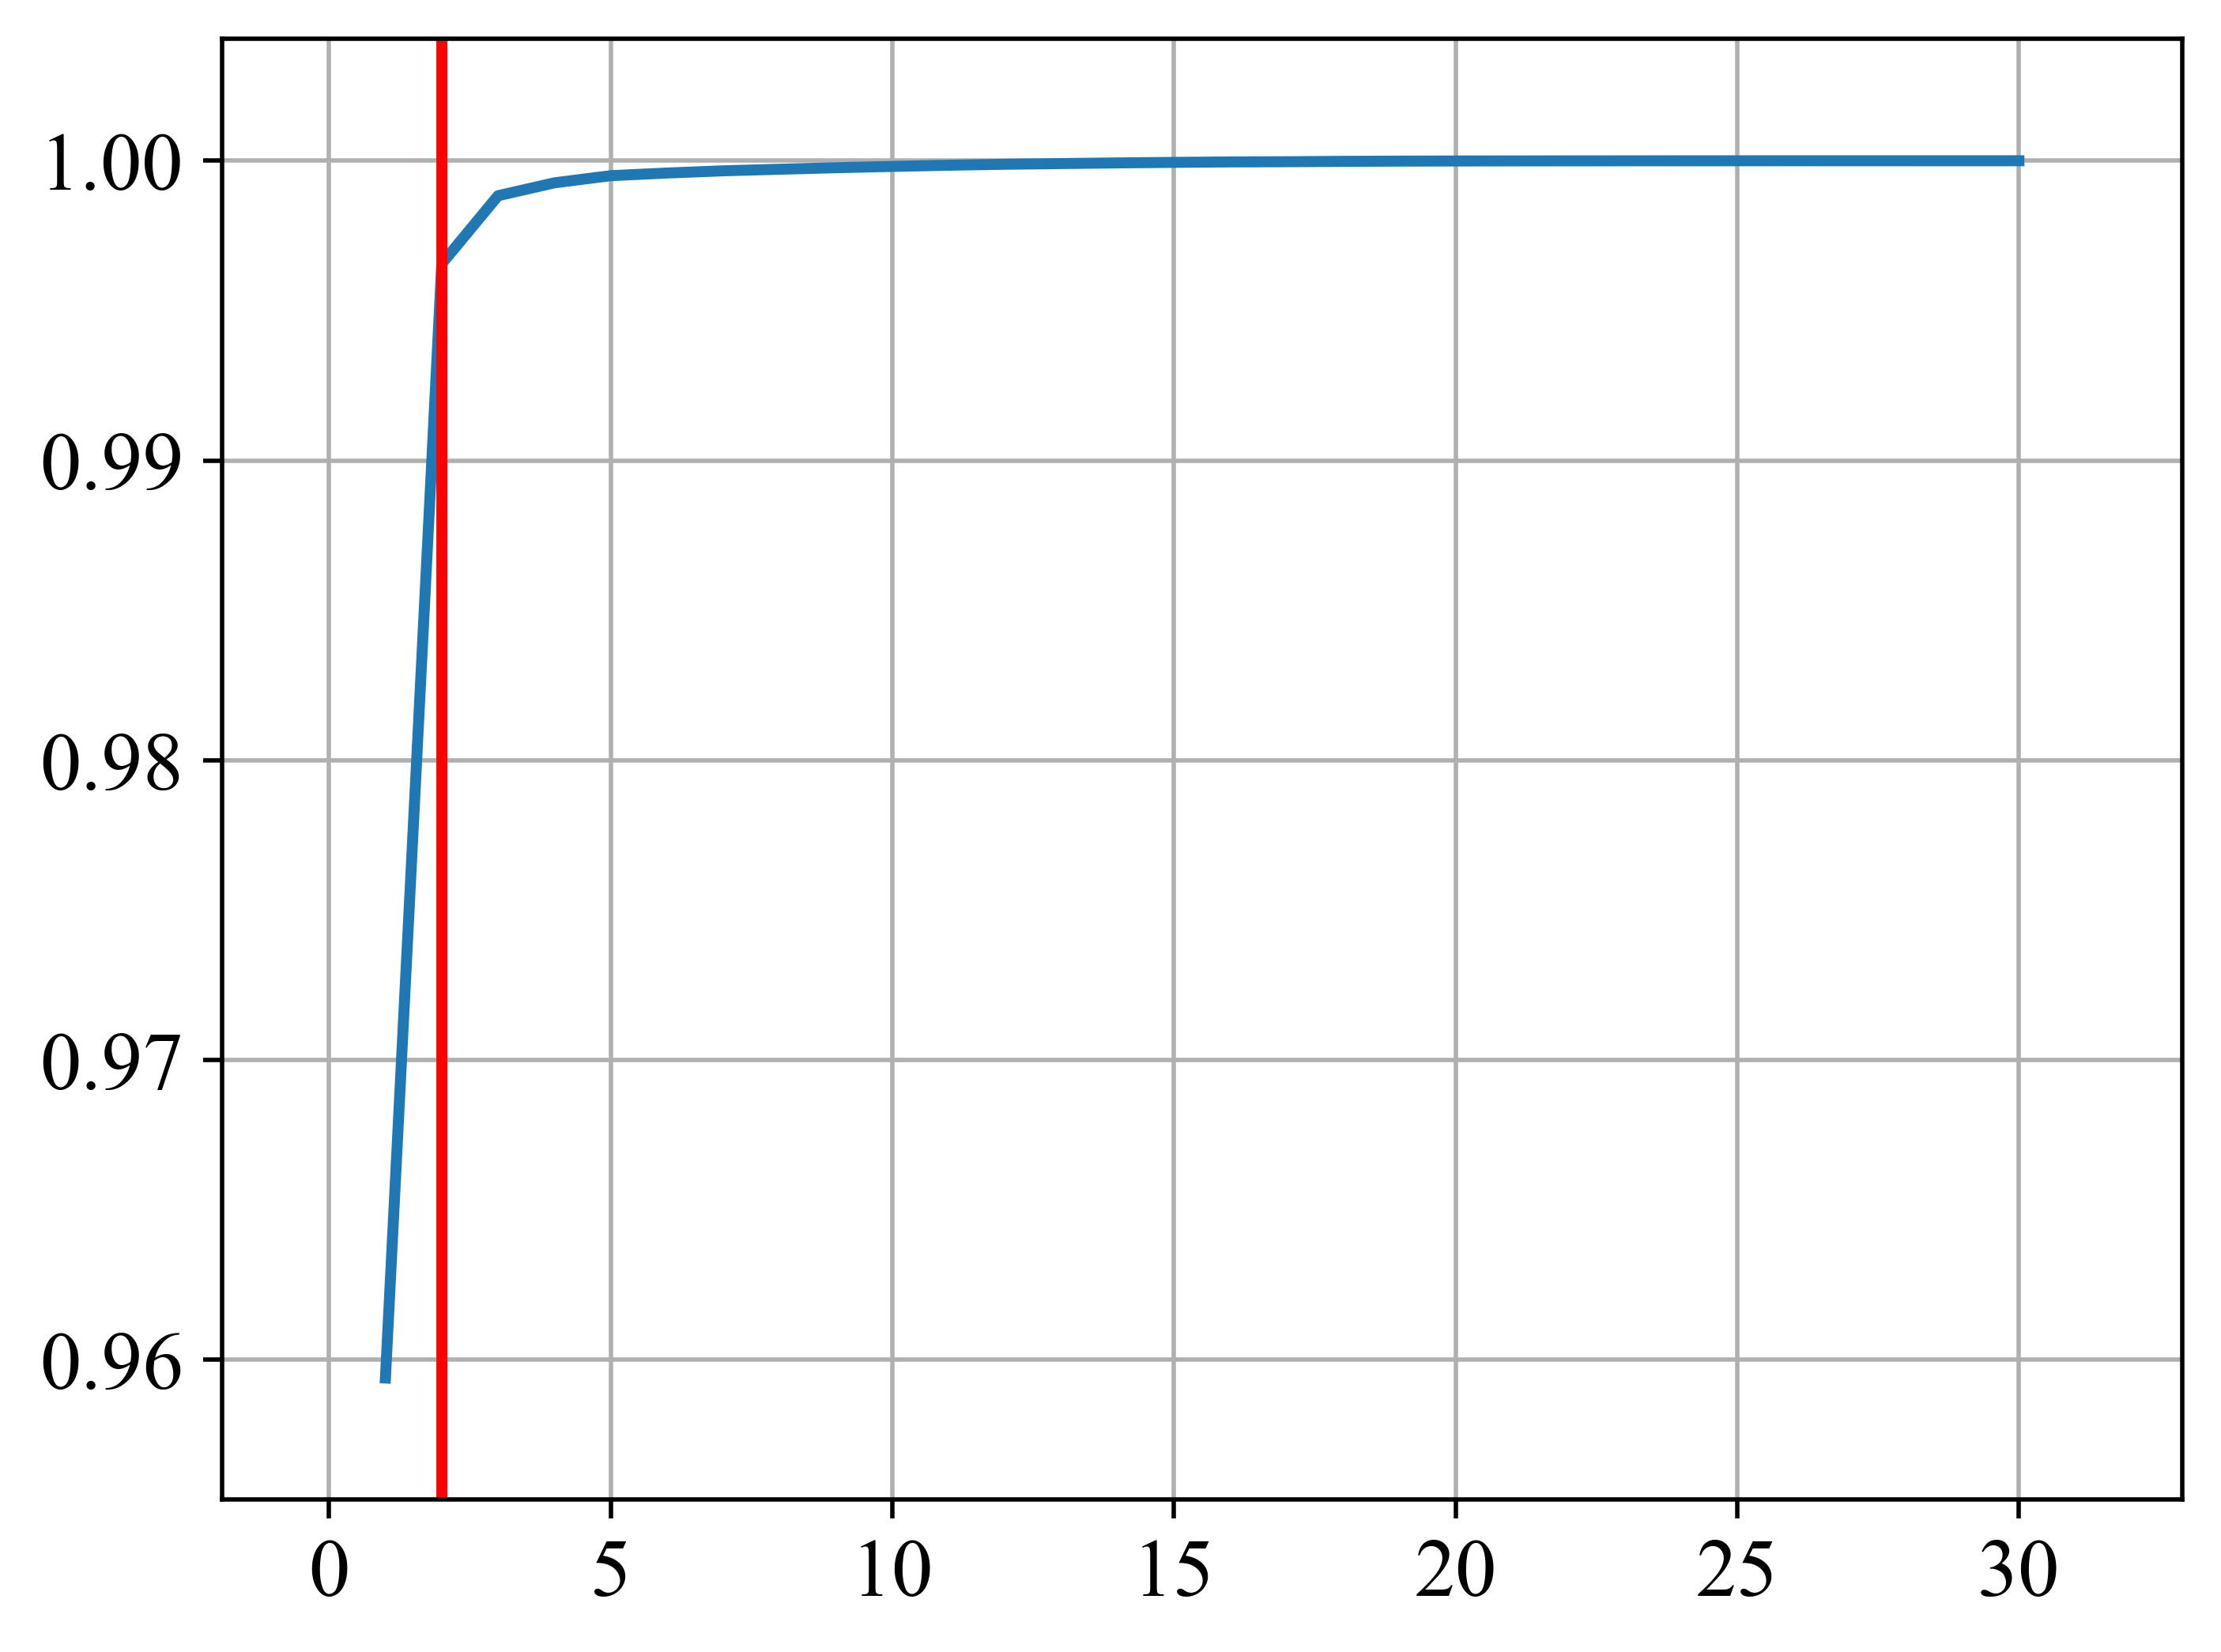

(784571, 123) (784571,) (172803, 123) (172803,)
(784571, 123) (784571,) (162826, 123) (172803,)
inf
finding PCA...
Done!


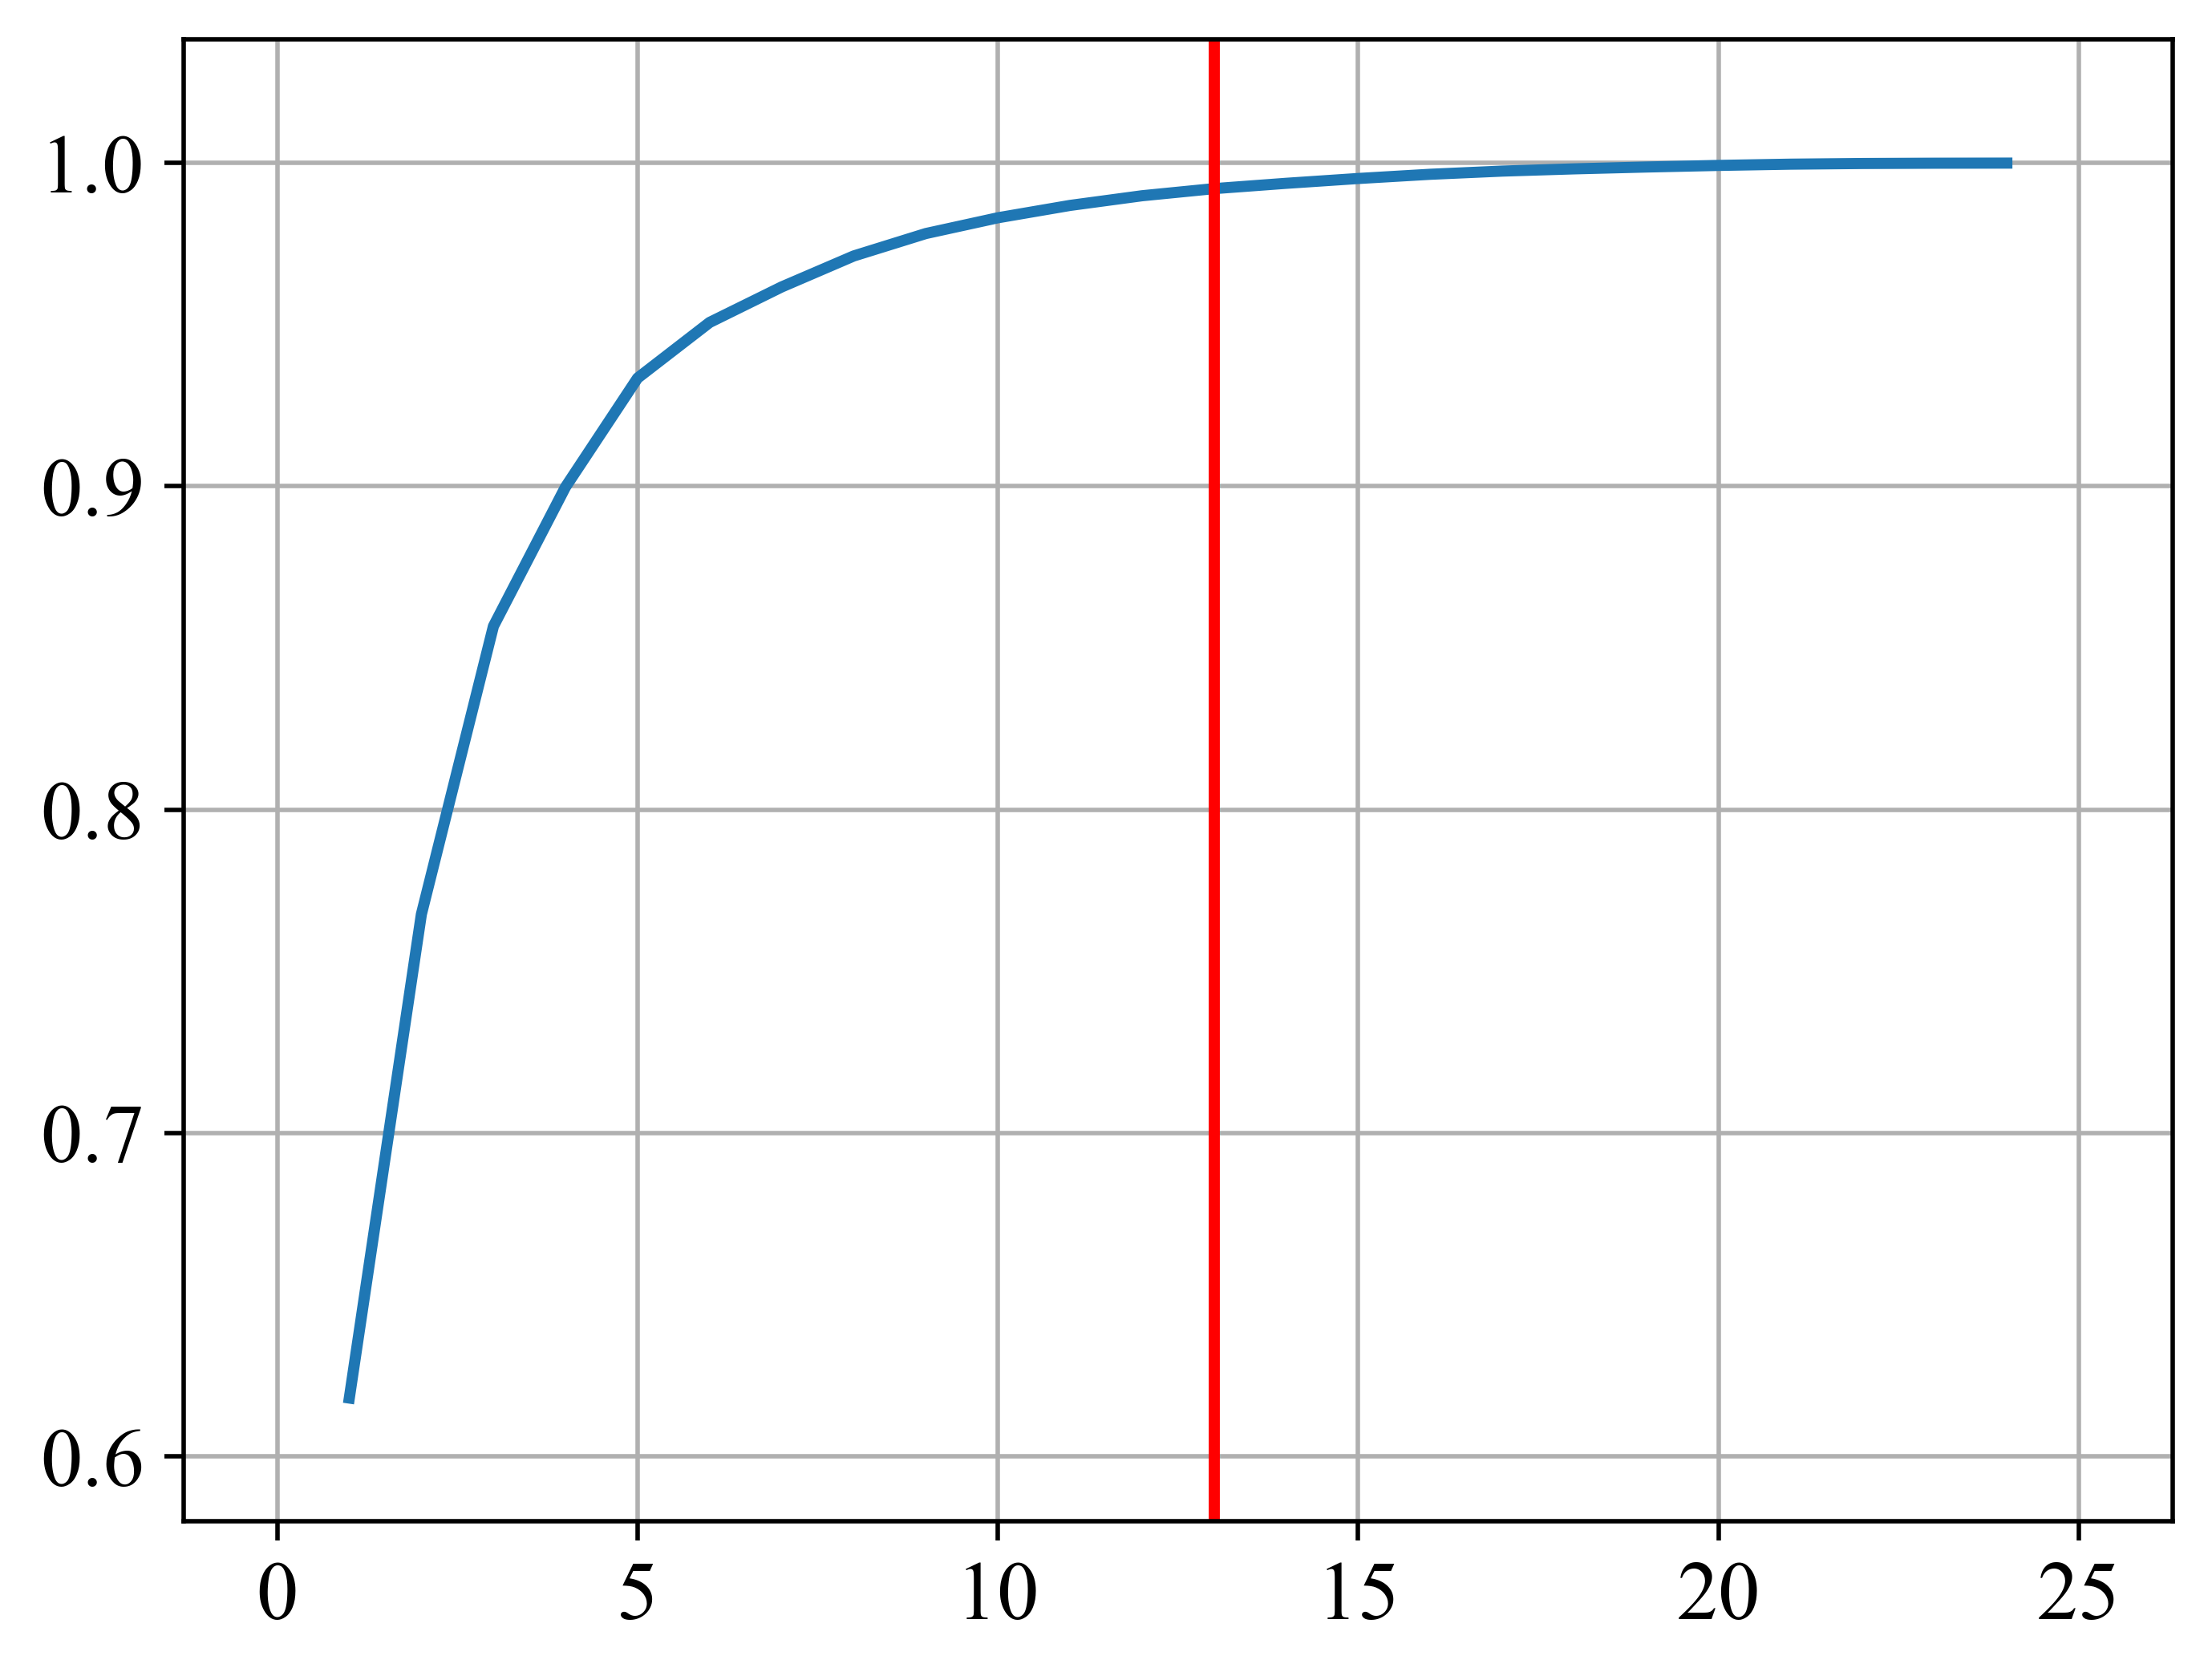

(132481, 25) (132481,) (87841, 25) (87841,)
(132481, 25) (132481,) (63460, 25) (87841,)
21.677072645761516
finding PCA...
Done!


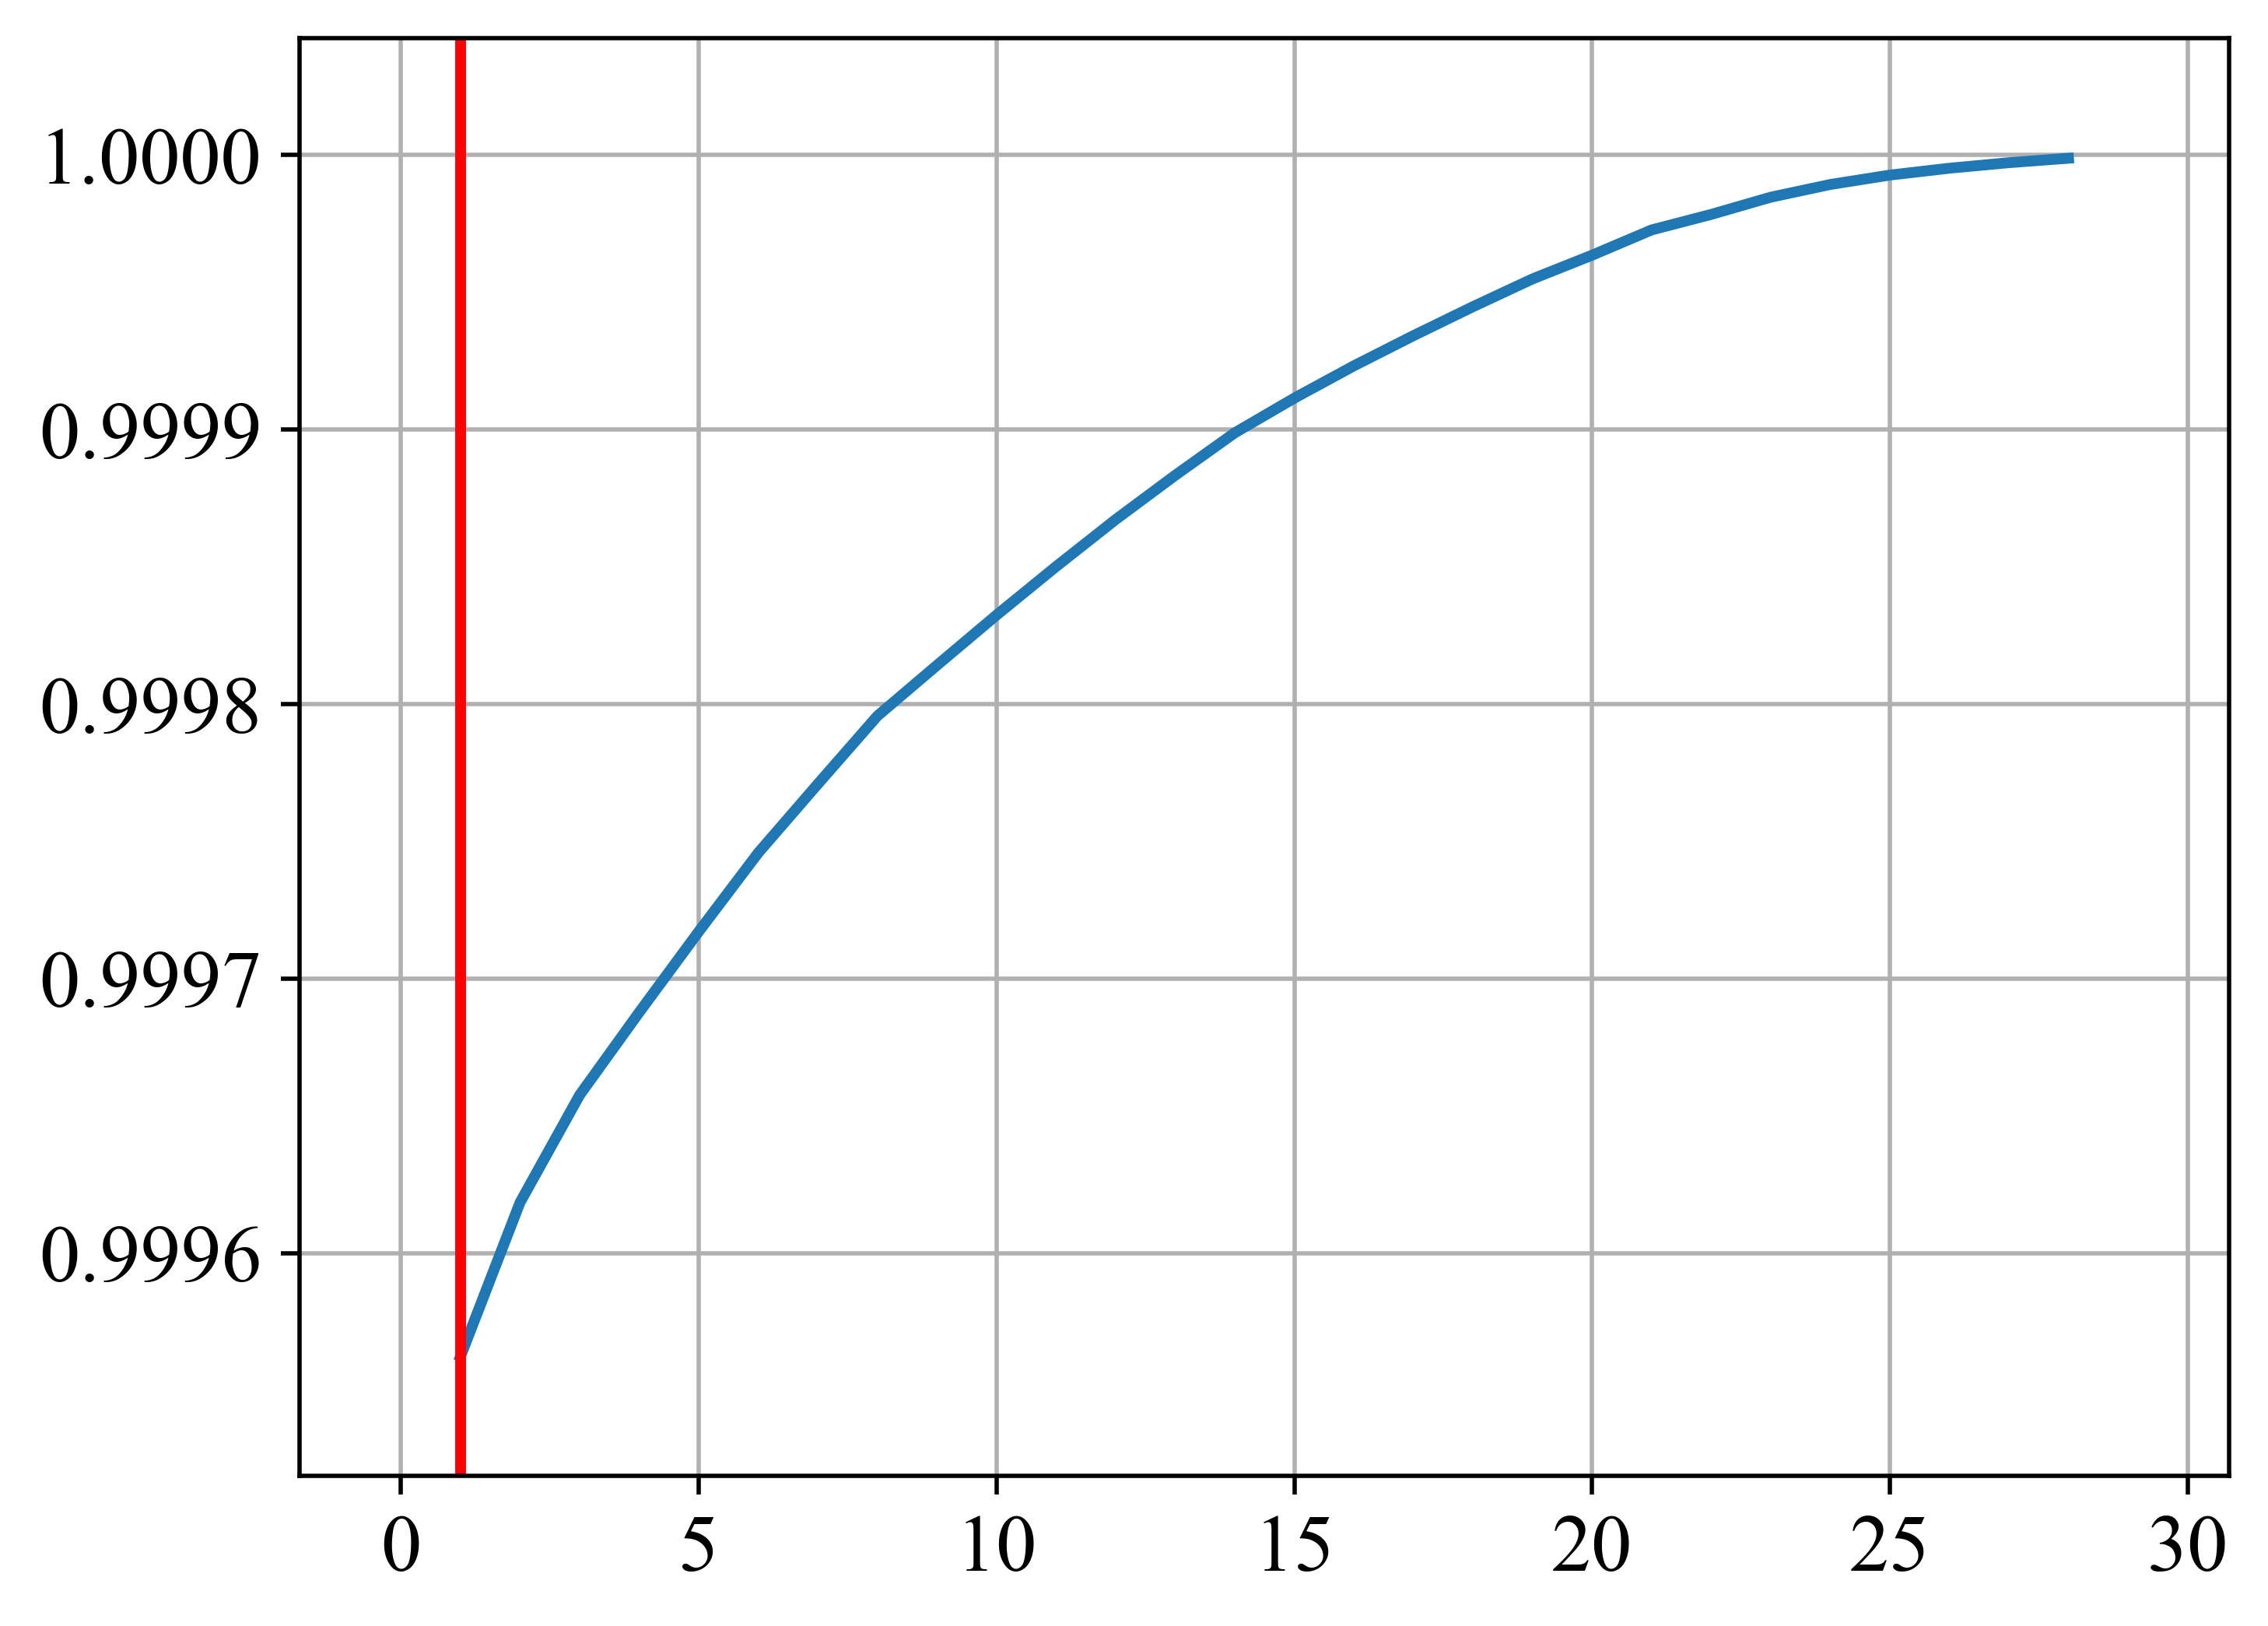

(142403, 29) (142403,) (142404, 29) (142404,)
(142403, 29) (142403,) (142181, 29) (142404,)
nan
finding PCA...
Done!


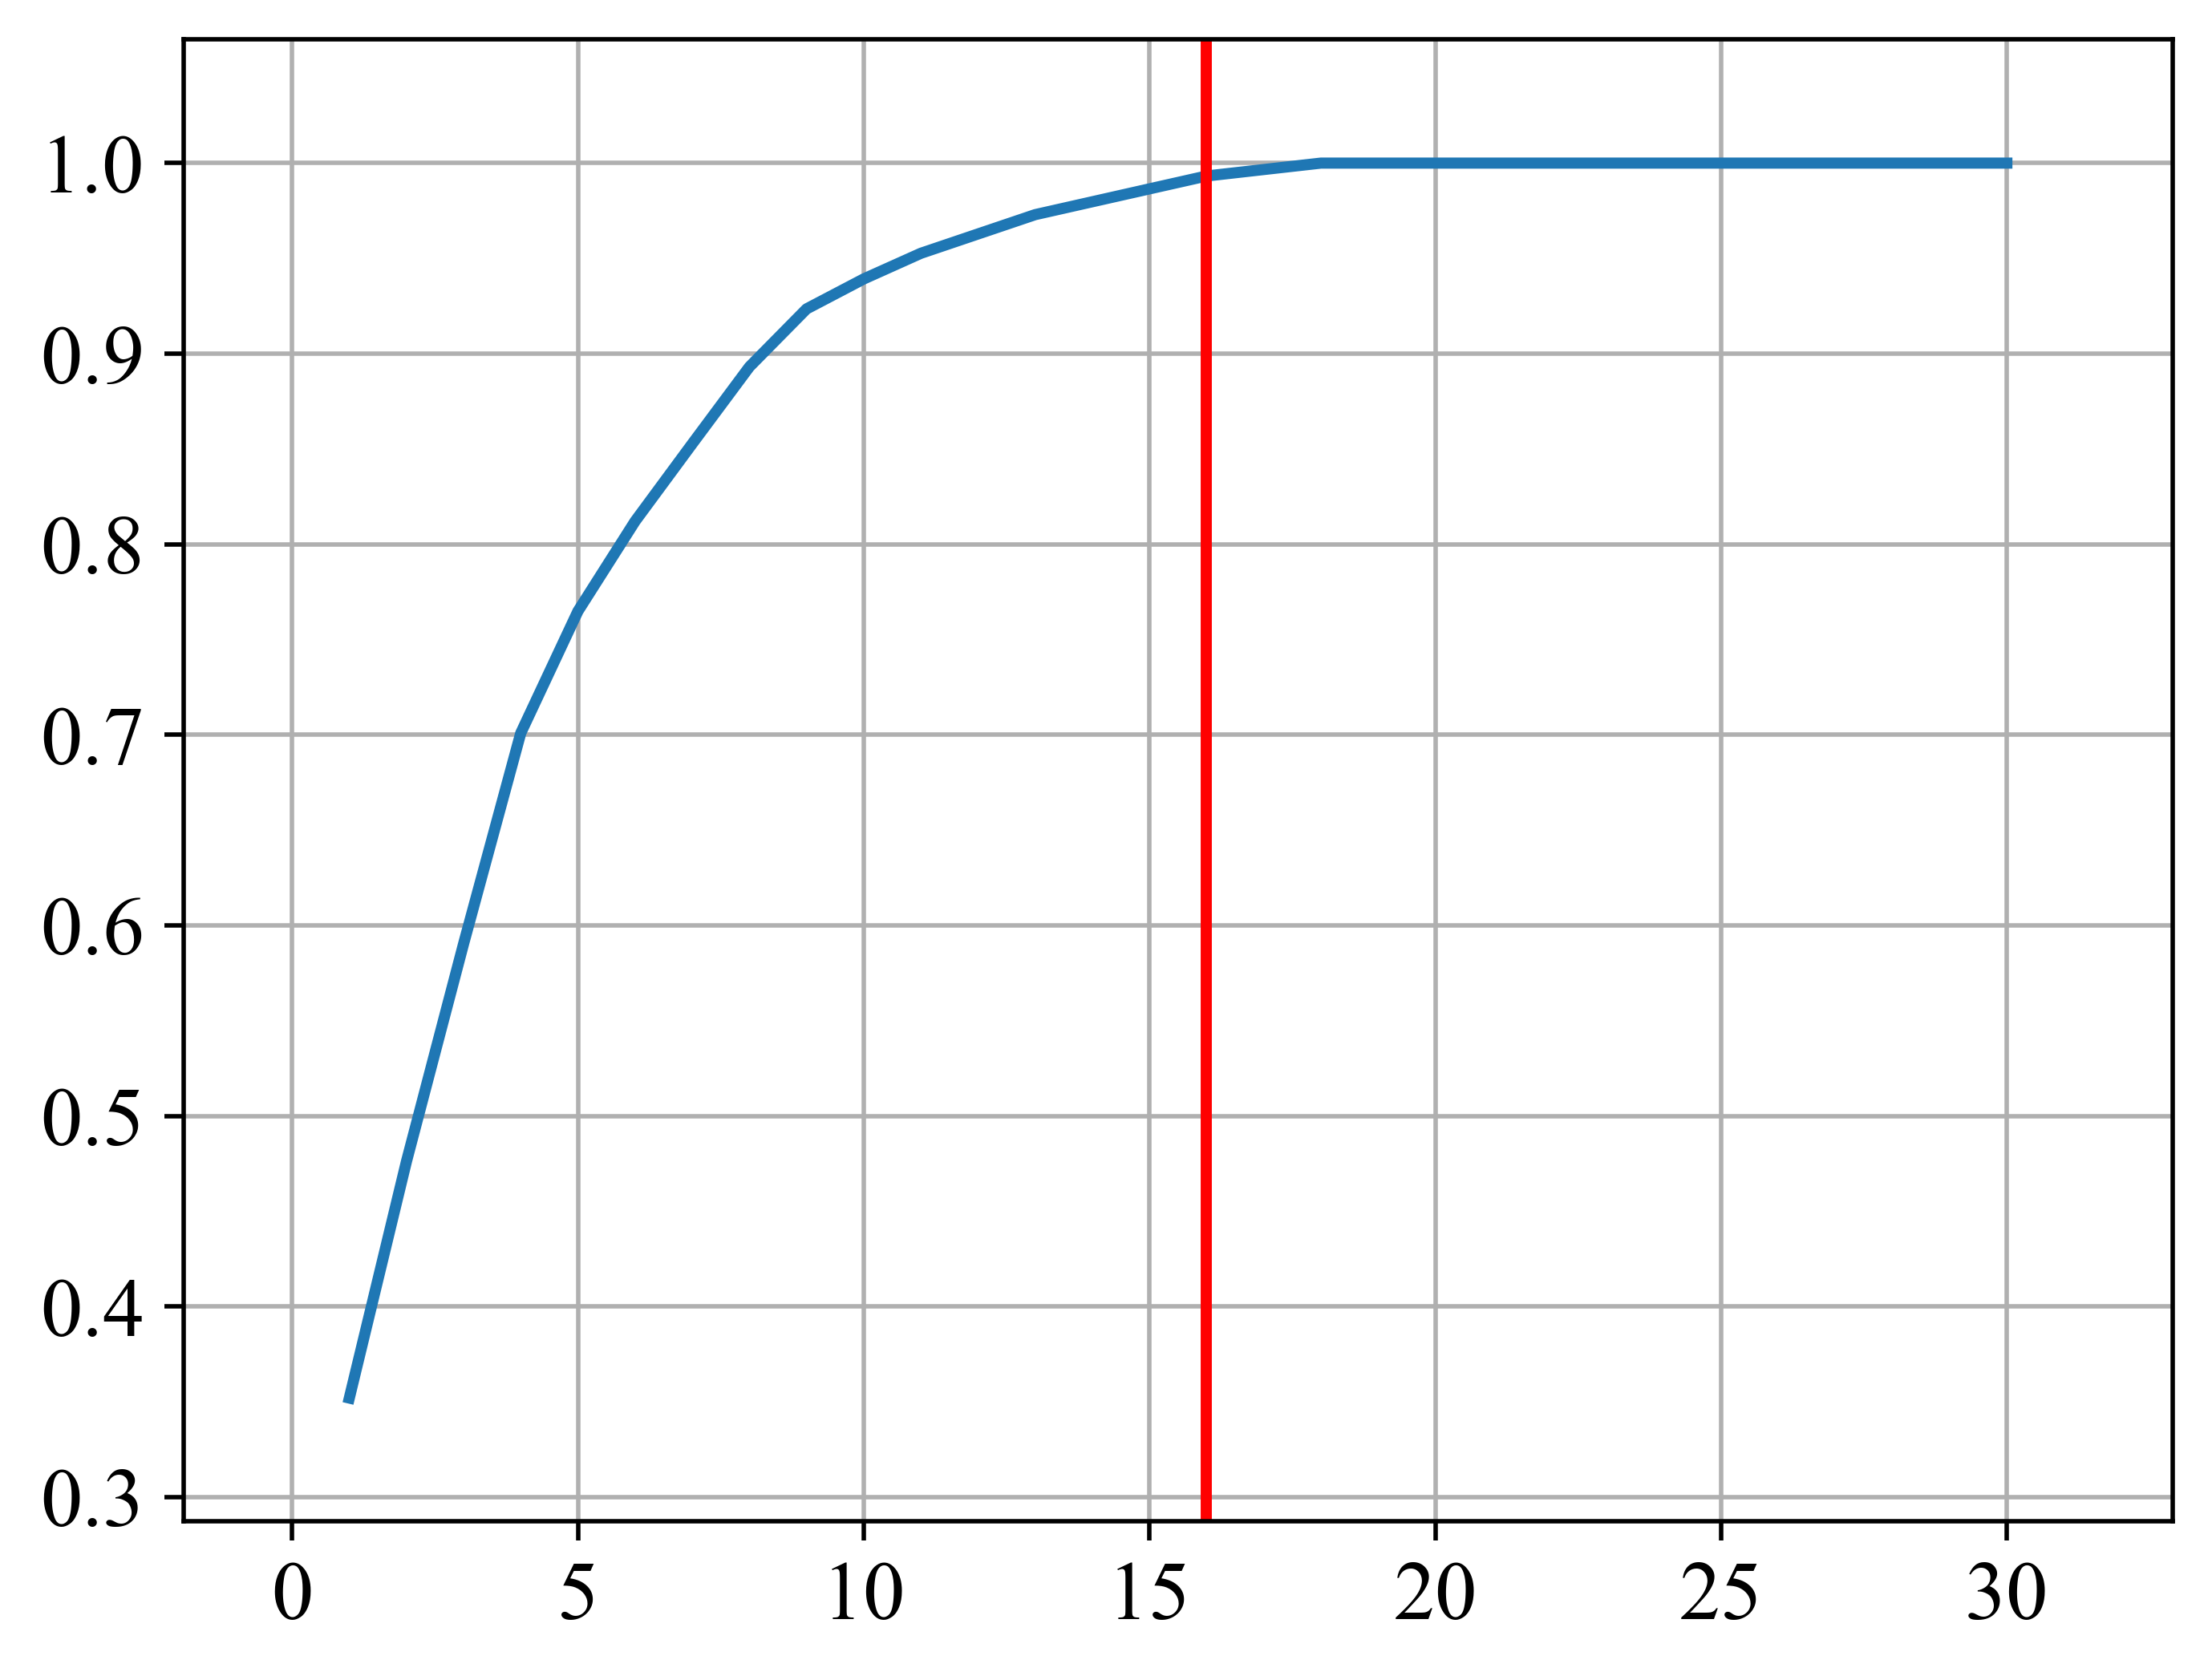

(3682, 55) (3682,) (2856, 55) (2856,)
(3682, 55) (3682,) (2836, 55) (2856,)
inf
finding PCA...
Done!


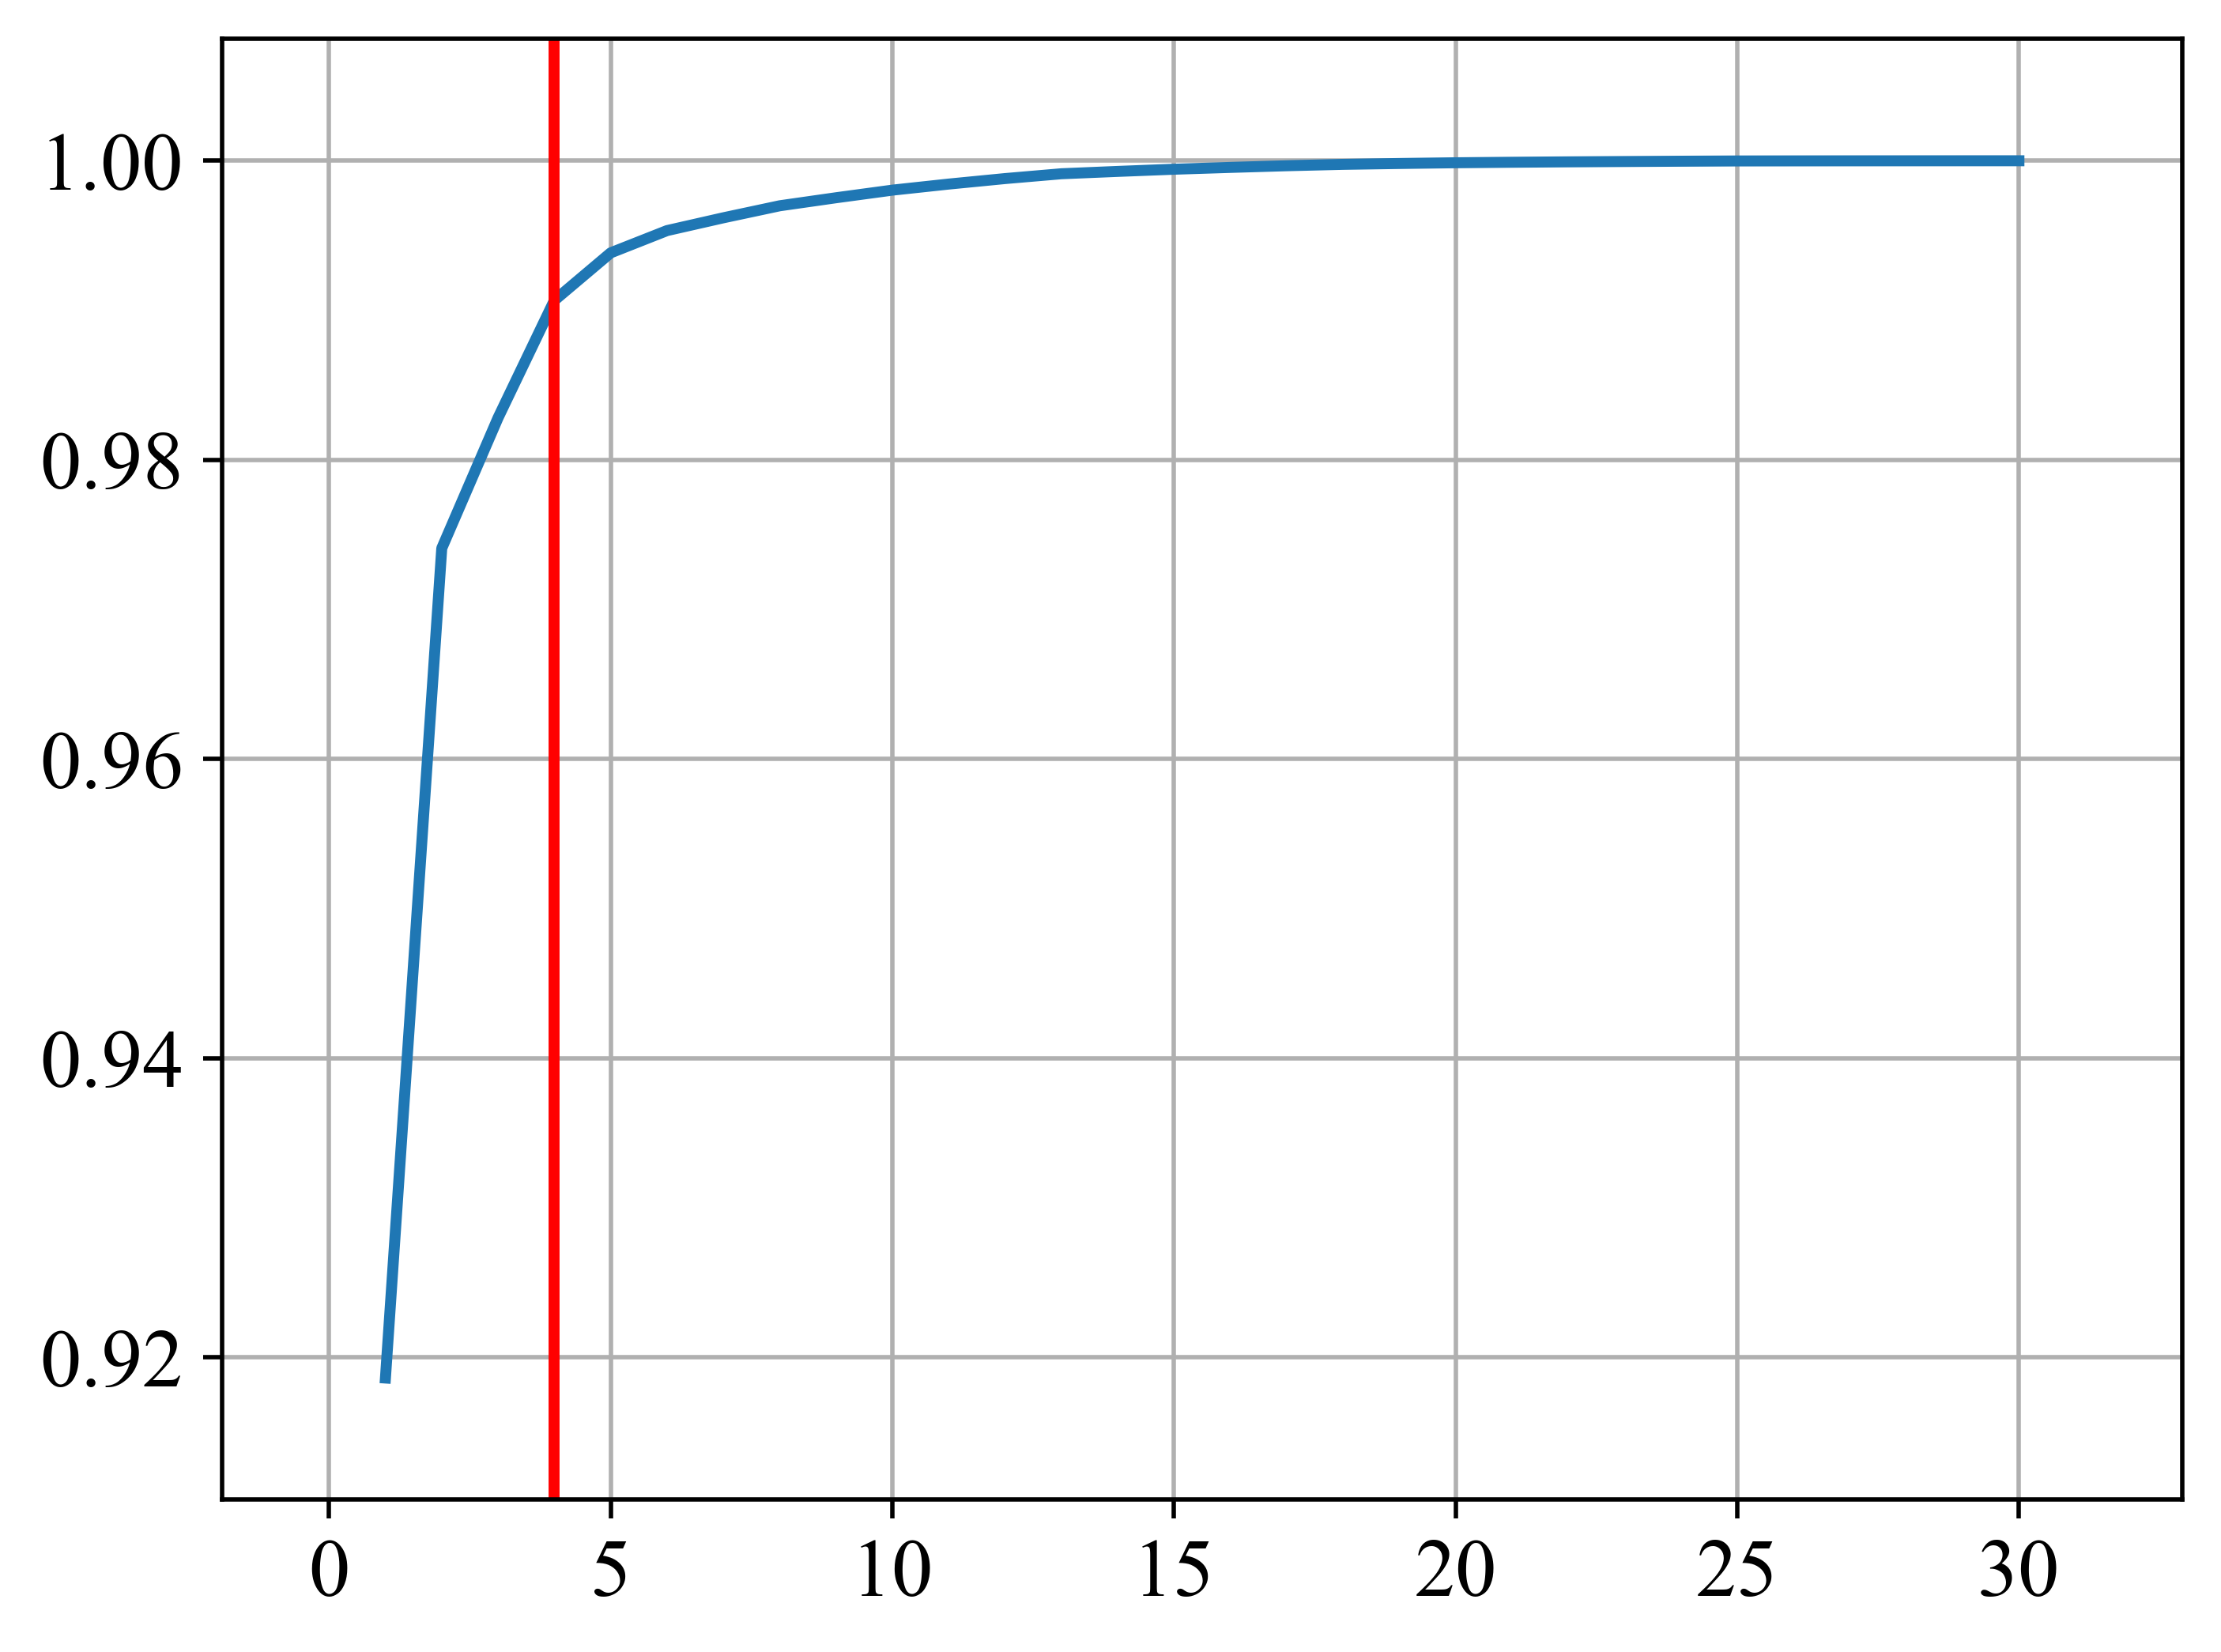

(23706, 38) (23706,) (23707, 38) (23707,)
(23706, 38) (23706,) (22987, 38) (23707,)
12.127360462568223
finding PCA...
Done!


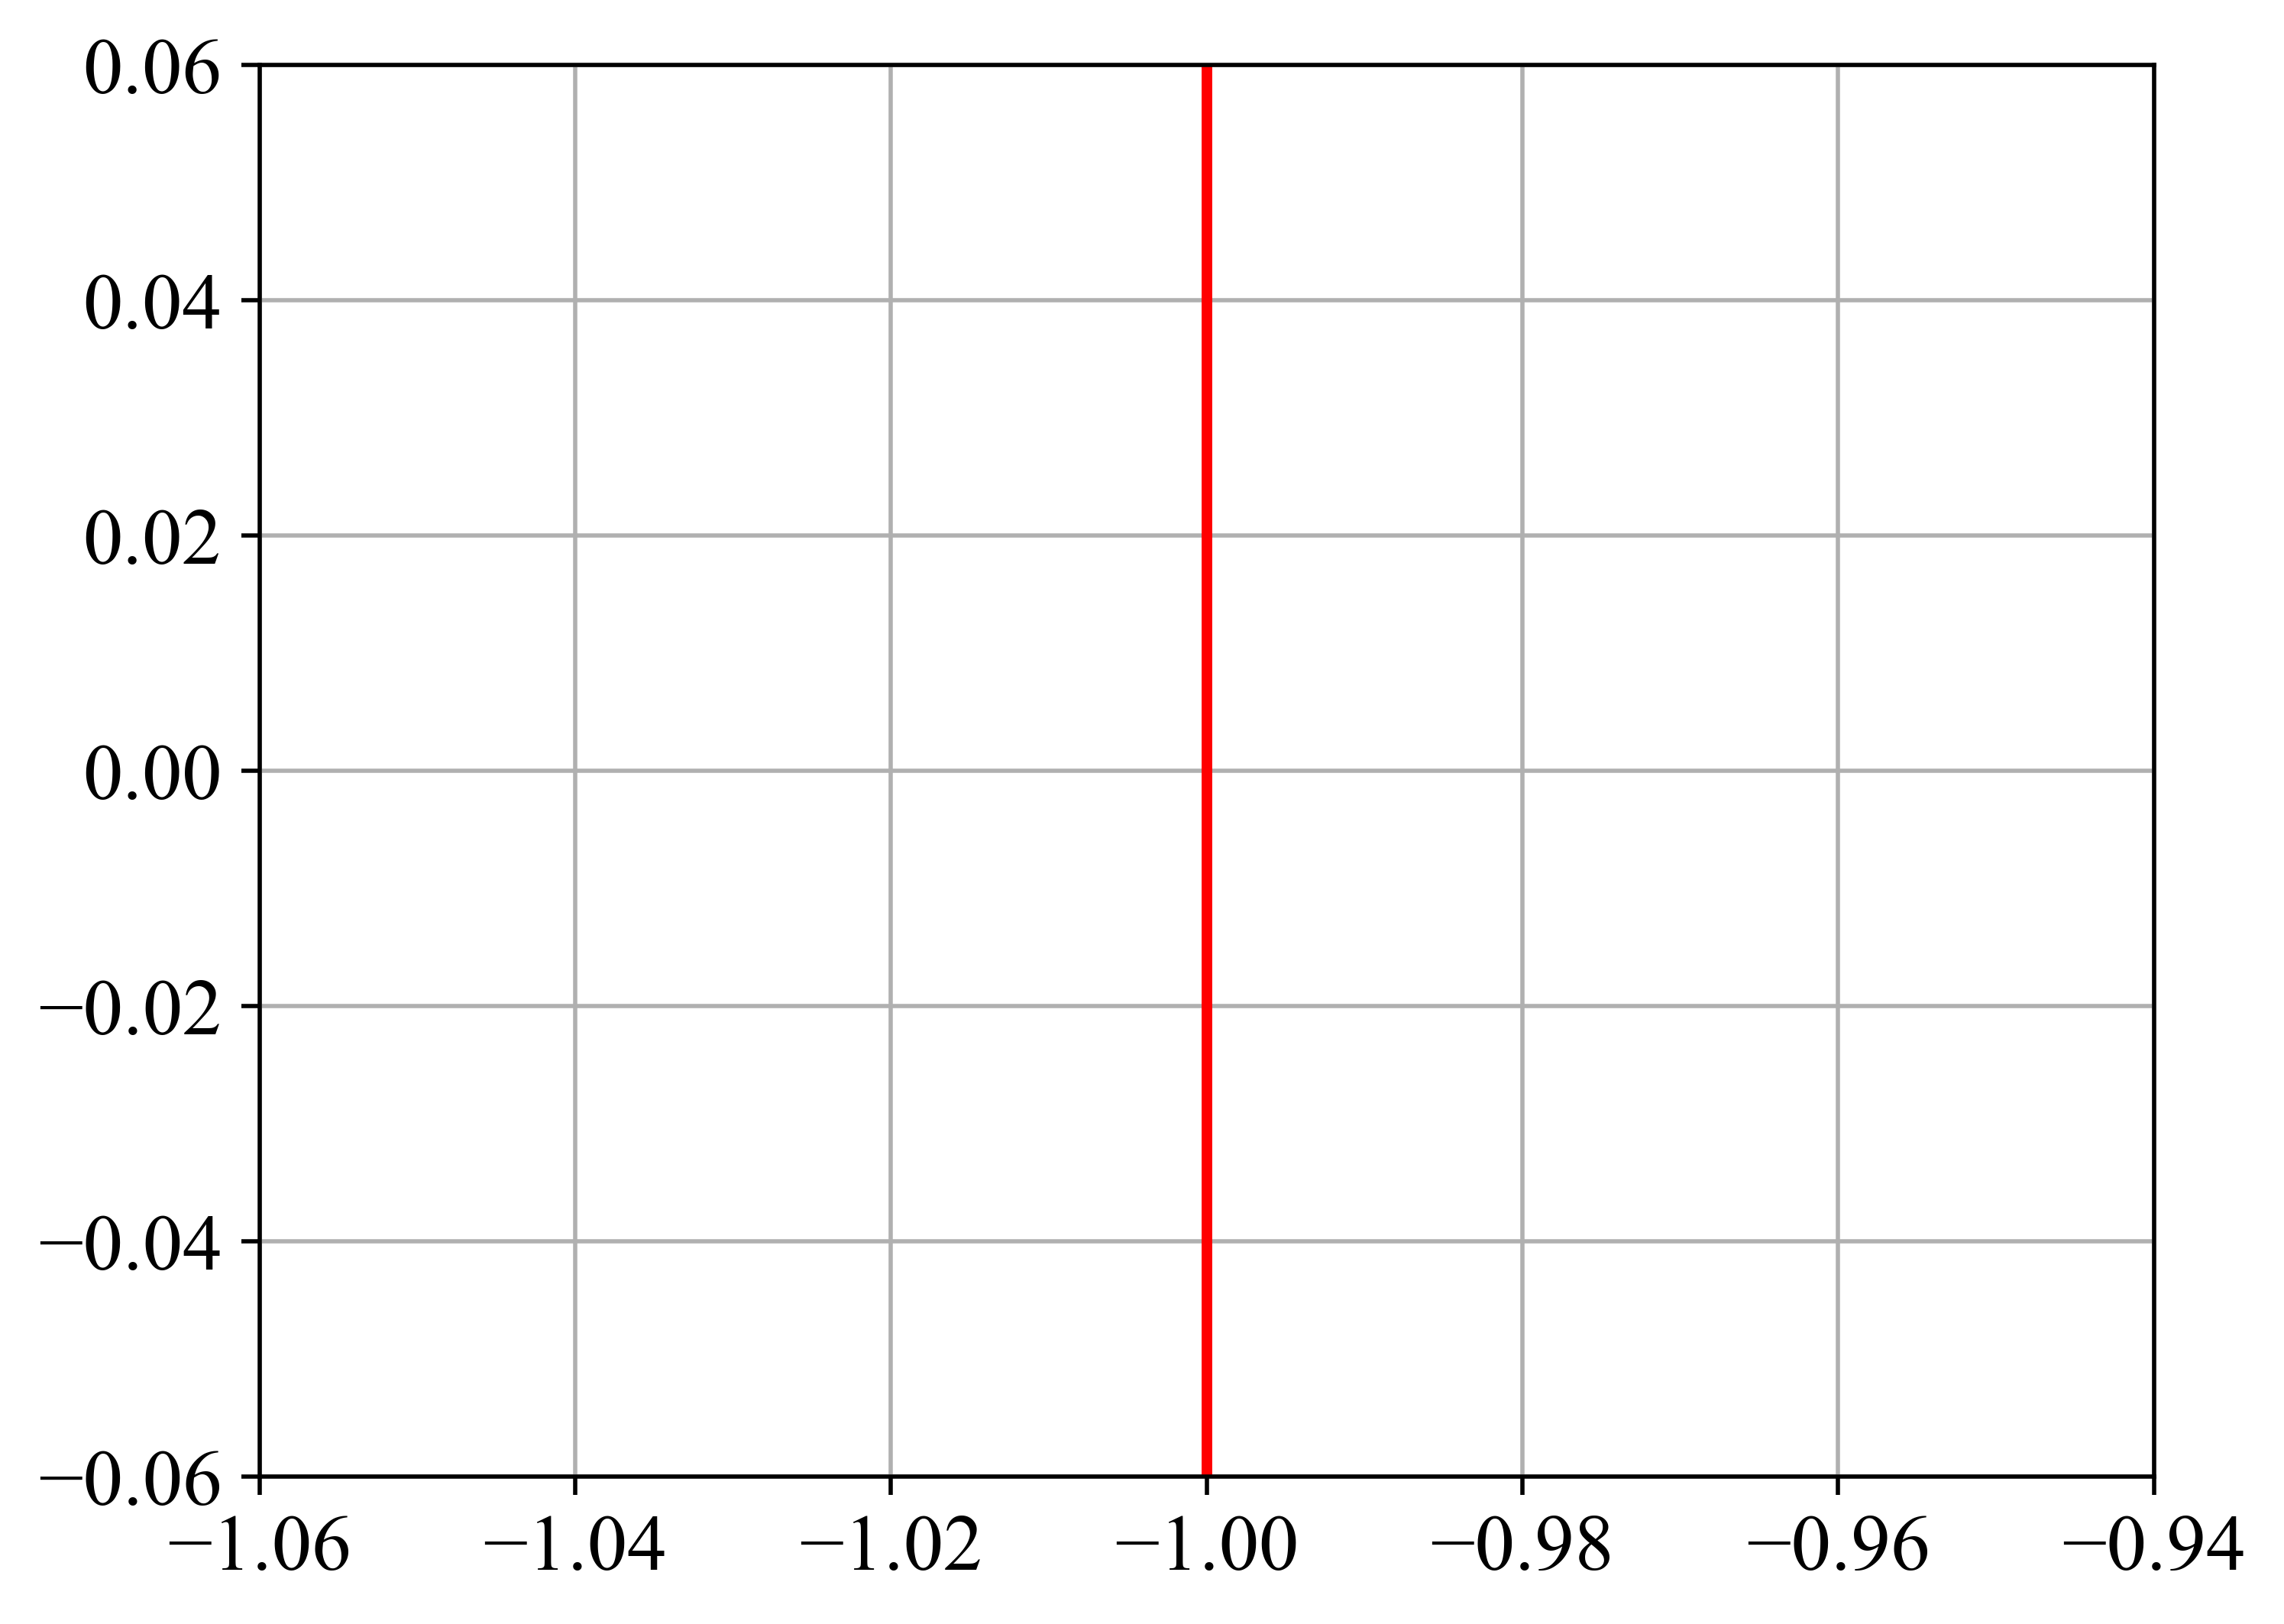

(400, 1) (400,) (1022, 1) (1022,)
(400, 1) (400,) (989, 1) (1022,)


InvalidParameterError: The 'n_components' parameter of PCA must be an int in the range [0, inf), a float in the range (0, 1), a str among {'mle'} or None. Got -1 instead.

In [58]:
datasets = ["SWaT", "WADI", "PSM", "CreditCard", "MSL_P-15", "SMD_machine-1-4", "yahoo_20", "Pump"]
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# PSM
train_X, train_y, test_X, test_y = DataFactory.load_PSM()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# Pump
train_X, train_y, test_X, test_y = DataFactory.load_Pump()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# Basic Bar Chart
plt.bar(datasets, entropies)
plt.title('Entropy of Kernel Density Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Entropy', fontsize=18)
plt.show()

<function DataFactory.load_PSM at 0x000001F32070F520>
(132481, 25) (132481,) (87841, 25) (87841,)
finding PCA...
Done!


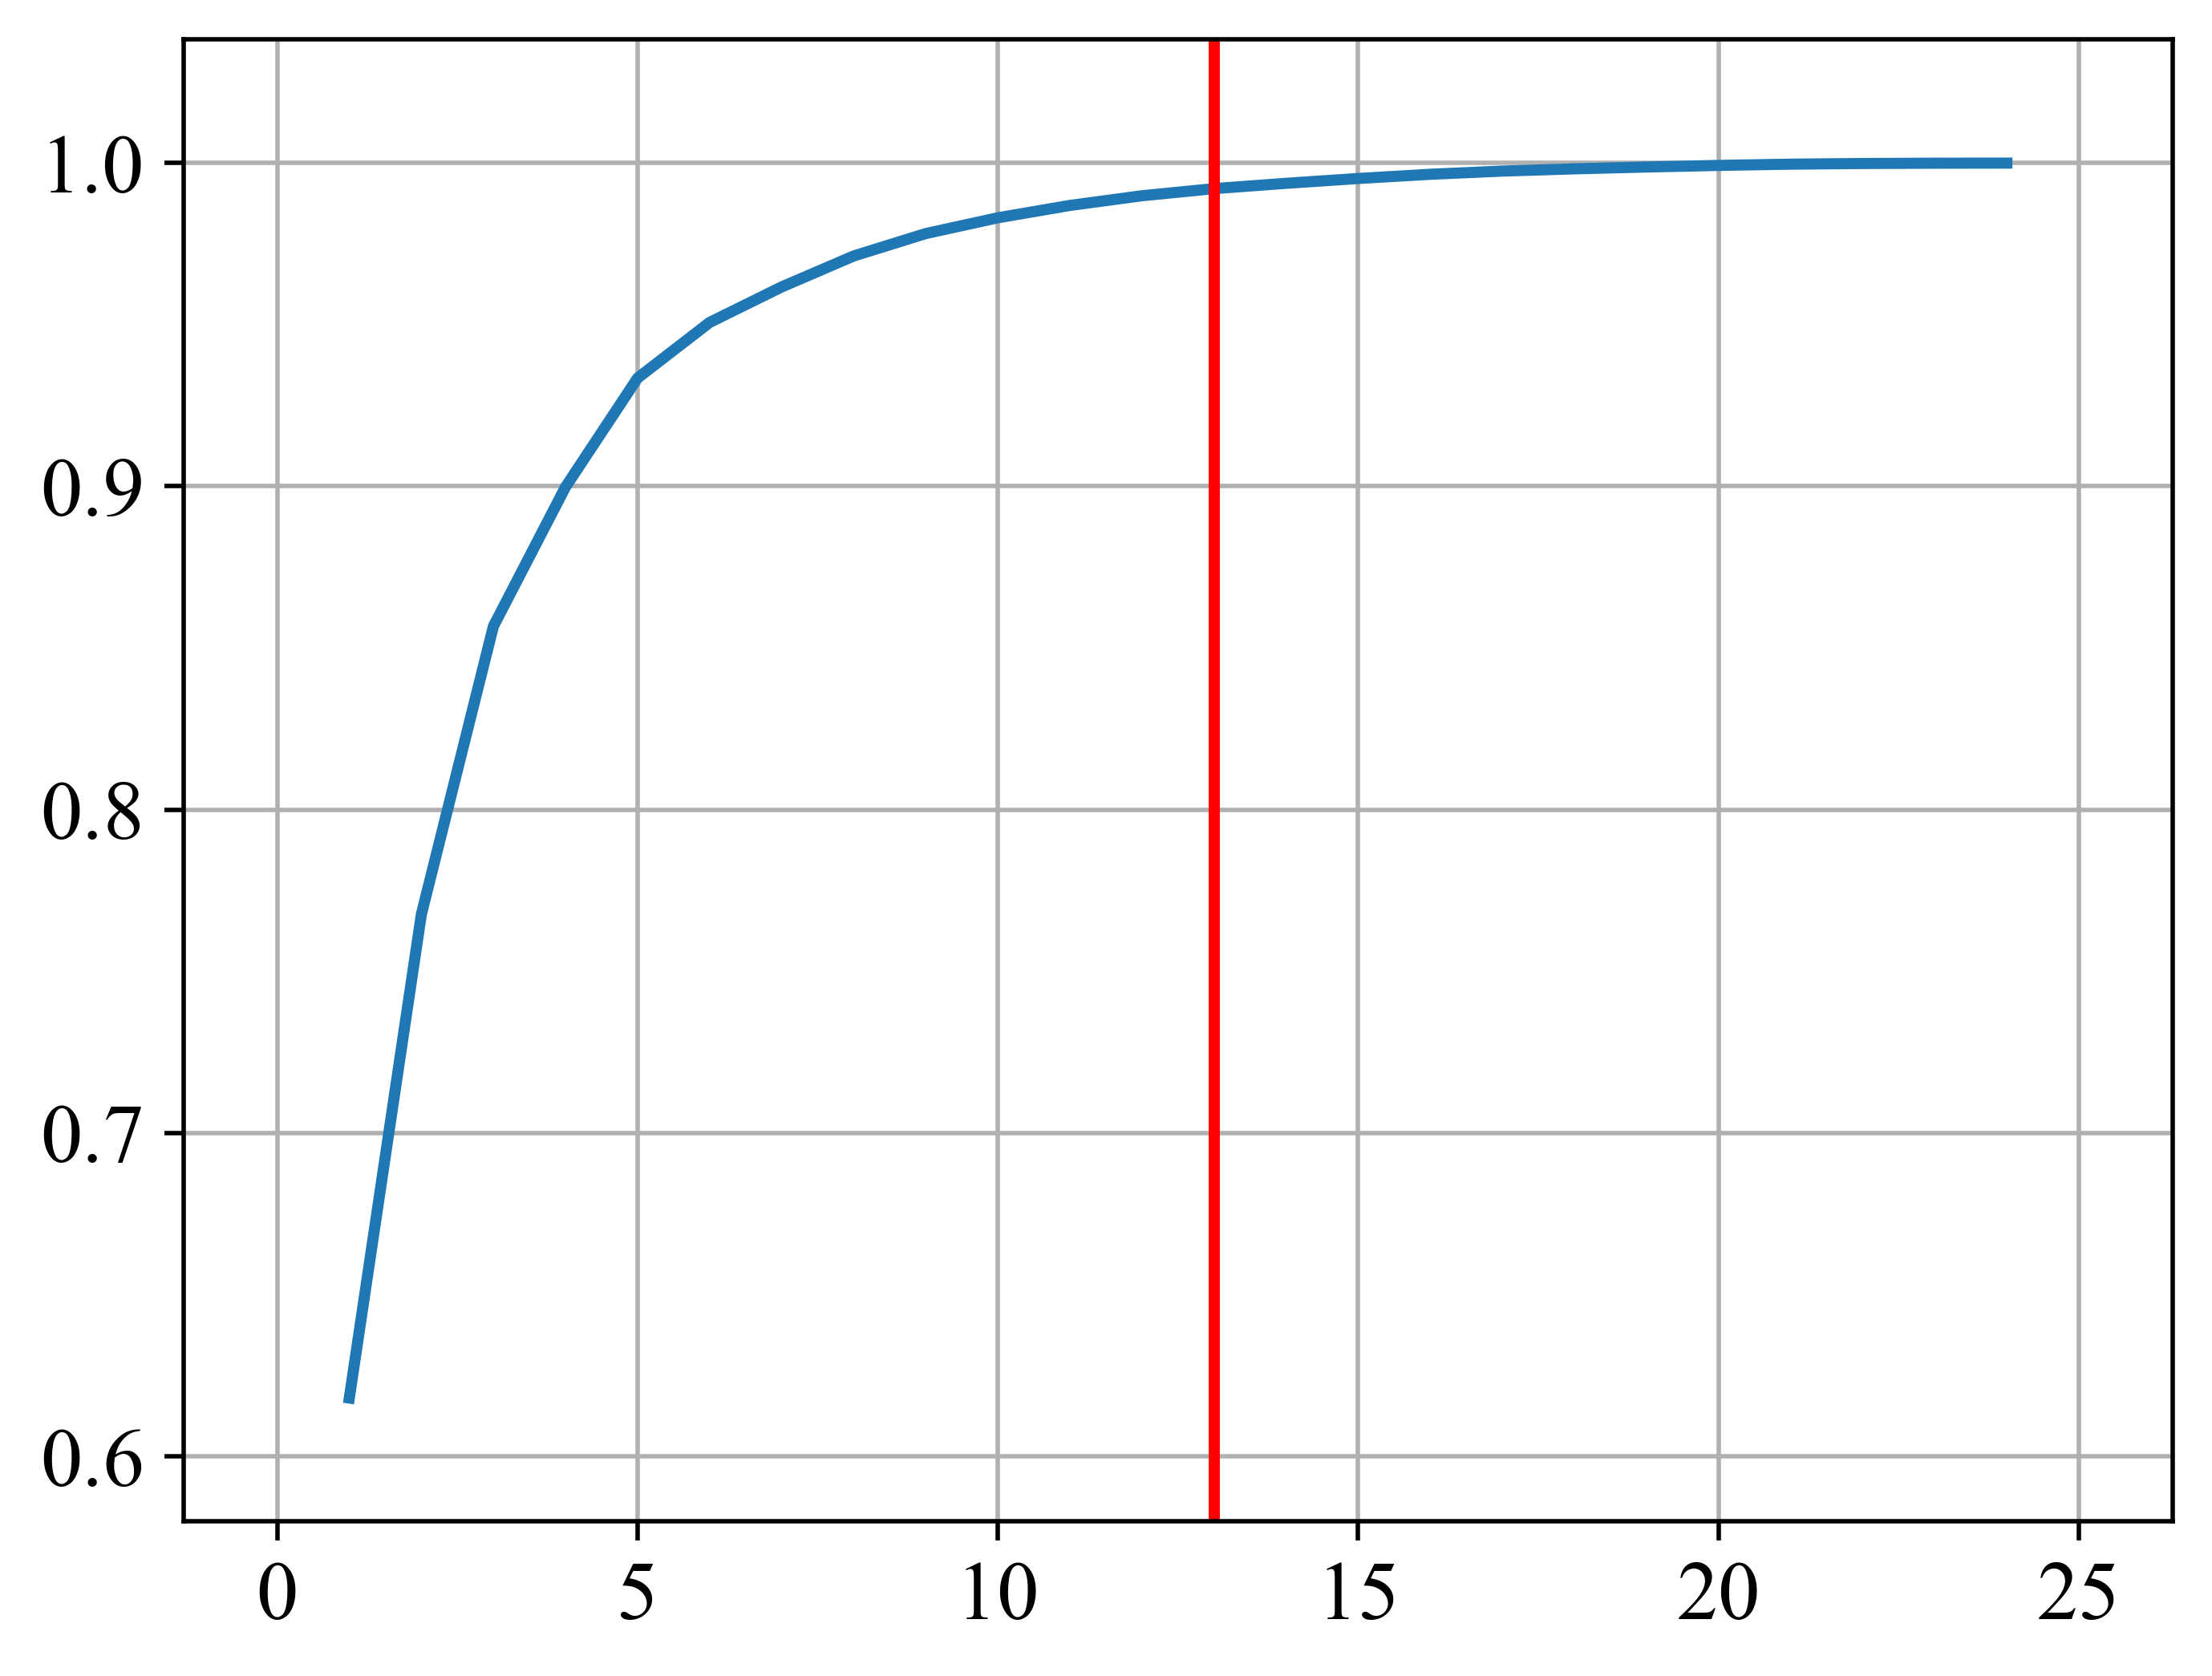

> c:\users\dongmin kim\appdata\local\temp\ipykernel_268\68748385.py(30)<module>()

ipdb> exit


In [37]:

entropies = []
fns = [DataFactory.load_PSM, DataFactory.load_SWaT, DataFactory.load_WADI, DataFactory.load_CreditCard]
for f in fns:
    print("="*20)
    print(f)
    train_X, train_y, test_X, test_y = f()
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    evar = []
    
    print("finding PCA...")
    T, C = train_X.shape
    x = range(1, min(C, 31))
    n_ = 0
    for n in x:
        pca = PCA(n_components=n)
        Xpca = pca.fit_transform(train_X)
        #print(Xpca.shape)
        #print(pca.explained_variance_ratio_)
        evar.append(sum(pca.explained_variance_ratio_))
        if n_ == 0 and sum(pca.explained_variance_ratio_) > 0.99 :
            n_ = n
    print("Done!")
    plt.plot(x, evar)
    plt.axvline(n_)
    plt.show()
    
    # kde of PCA'ed outputs.
    pca = PCA(n_components=n_) 
    Xpca_train = pca.fit_transform(train_X)
    Xpca_test = pca.fit_transform(test_X)
    
    #Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
    #XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
    
    #grid = np.linspace(Xm, XM, 100).T
    
    e = kldiv(Xpca_train, Xpca_test)
    #e = entropy(test_kde(grid), train_kde(grid)) # how much information should be gained, from train, to test.
    print(e)
    entropies.append(e)
    print("="*20)
    
# Basic Bar Chart
plt.bar(datasets, entropies)
plt.title('Entropy of Kernel Density Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Entropy', fontsize=18)
plt.show()
    

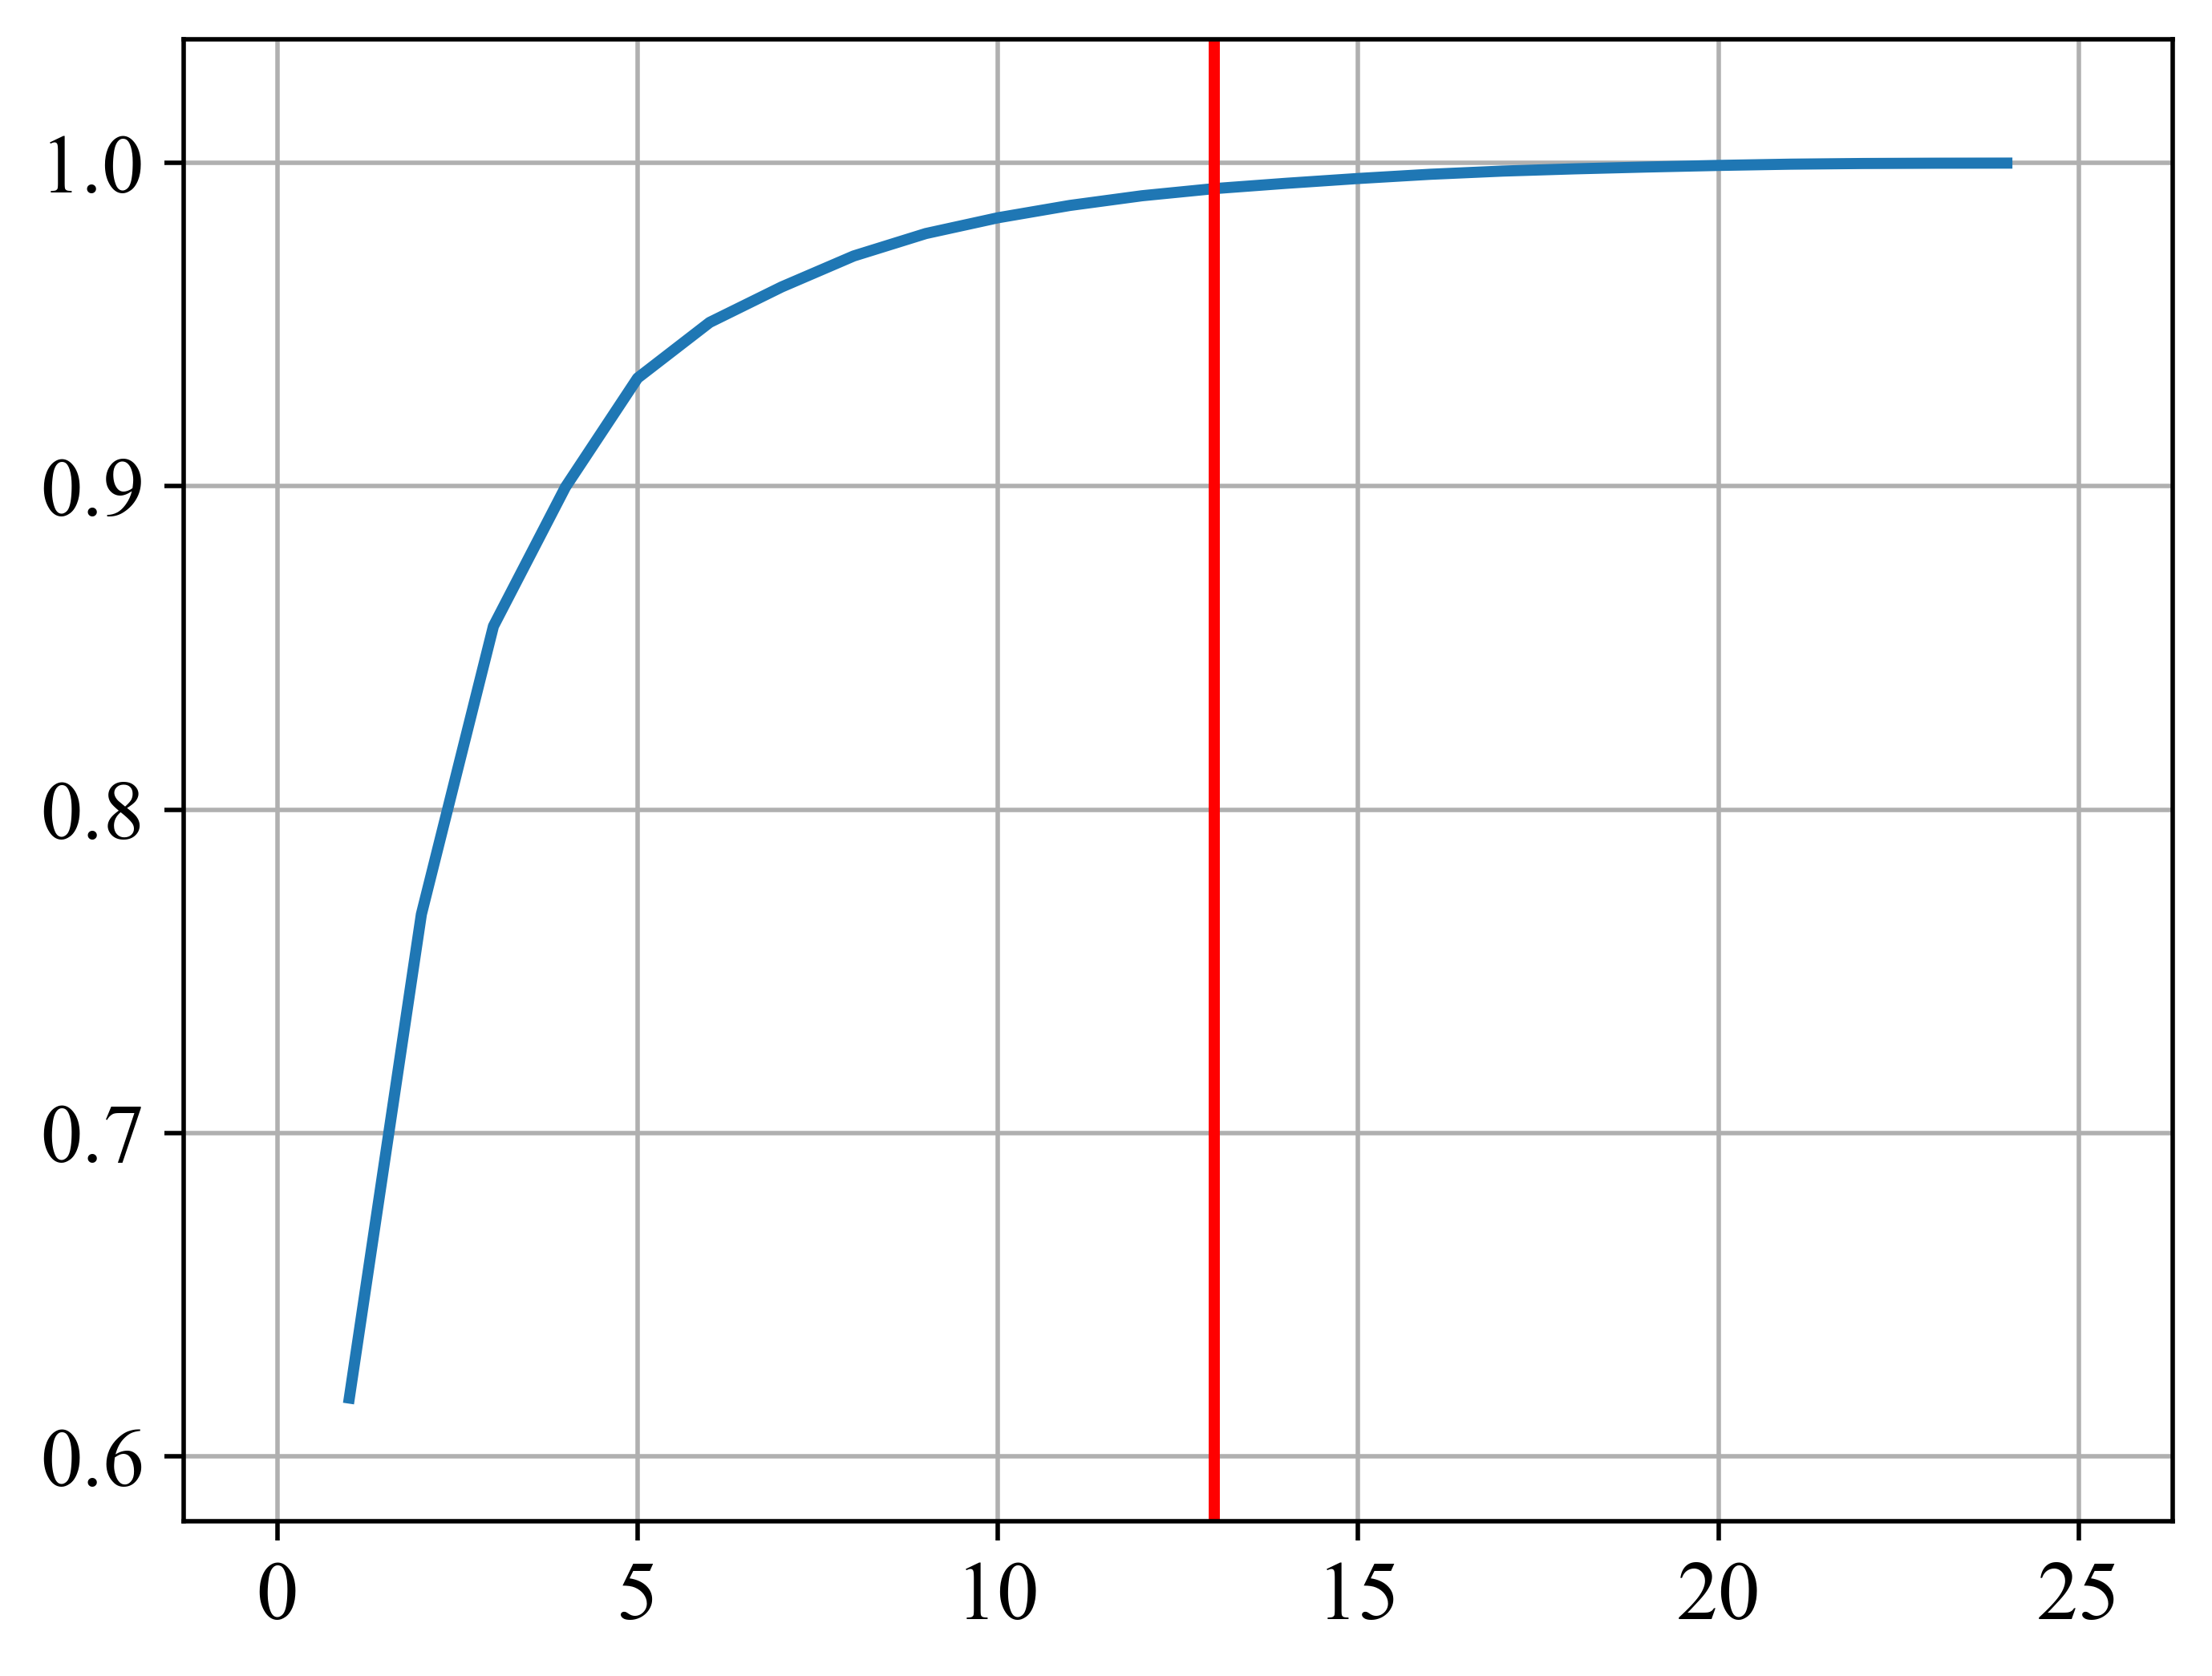

In [32]:
# PSM
train_X, train_y, test_X, test_y = DataFactory.load_PSM()
T, C = train_X.shape
evar = []
x = range(1, min(31, C))
n_ = 0
for n in x:
    pca = PCA(n_components=n) # 주성분을 몇개로 할지 결정
    Xpca = pca.fit_transform(train_X)
    #print(Xpca.shape)
    #print(pca.explained_variance_ratio_)
    evar.append(sum(pca.explained_variance_ratio_))
    if n_ == 0 and sum(pca.explained_variance_ratio_) > 0.99 :
        n_ = n
plt.plot(x, evar)
plt.axvline(n_)
plt.show()

In [33]:
pca = PCA(n_components=n_) 
Xpca_train = pca.fit_transform(train_X)
Xpca_test = pca.fit_transform(test_X)

In [36]:
kldiv(Xpca_train, Xpca_test)

22.211449826485612

## gaussian kde

In [57]:
train_kde = gaussian_kde(Xpca_train.T)
test_kde = gaussian_kde(Xpca_test.T)

In [58]:
np.concatenate([train_X, test_X]).shape

(946716, 51)

In [59]:
Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)

In [63]:
grid = np.linspace(Xm, XM, 100).T

In [64]:
grid.shape

(13, 100)

In [65]:
entropy(train_kde(grid), test_kde(grid))

105.66848097653478

In [18]:

#gaussian_kde(train_X[:, c])

xmin = train_X[:, c].min()
xmax = train_X[:, c].max()

grid = np.linspace(xmin, xmax, 100)
grid

array([-4.01381445, -3.95491649, -3.89601853, -3.83712058, -3.77822262,
       -3.71932466, -3.6604267 , -3.60152875, -3.54263079, -3.48373283,
       -3.42483487, -3.36593692, -3.30703896, -3.248141  , -3.18924304,
       -3.13034508, -3.07144713, -3.01254917, -2.95365121, -2.89475325,
       -2.8358553 , -2.77695734, -2.71805938, -2.65916142, -2.60026347,
       -2.54136551, -2.48246755, -2.42356959, -2.36467163, -2.30577368,
       -2.24687572, -2.18797776, -2.1290798 , -2.07018185, -2.01128389,
       -1.95238593, -1.89348797, -1.83459002, -1.77569206, -1.7167941 ,
       -1.65789614, -1.59899819, -1.54010023, -1.48120227, -1.42230431,
       -1.36340635, -1.3045084 , -1.24561044, -1.18671248, -1.12781452,
       -1.06891657, -1.01001861, -0.95112065, -0.89222269, -0.83332474,
       -0.77442678, -0.71552882, -0.65663086, -0.59773291, -0.53883495,
       -0.47993699, -0.42103903, -0.36214107, -0.30324312, -0.24434516,
       -0.1854472 , -0.12654924, -0.06765129, -0.00875333,  0.05

In [19]:
kernel = gaussian_kde(train_X[:, c])

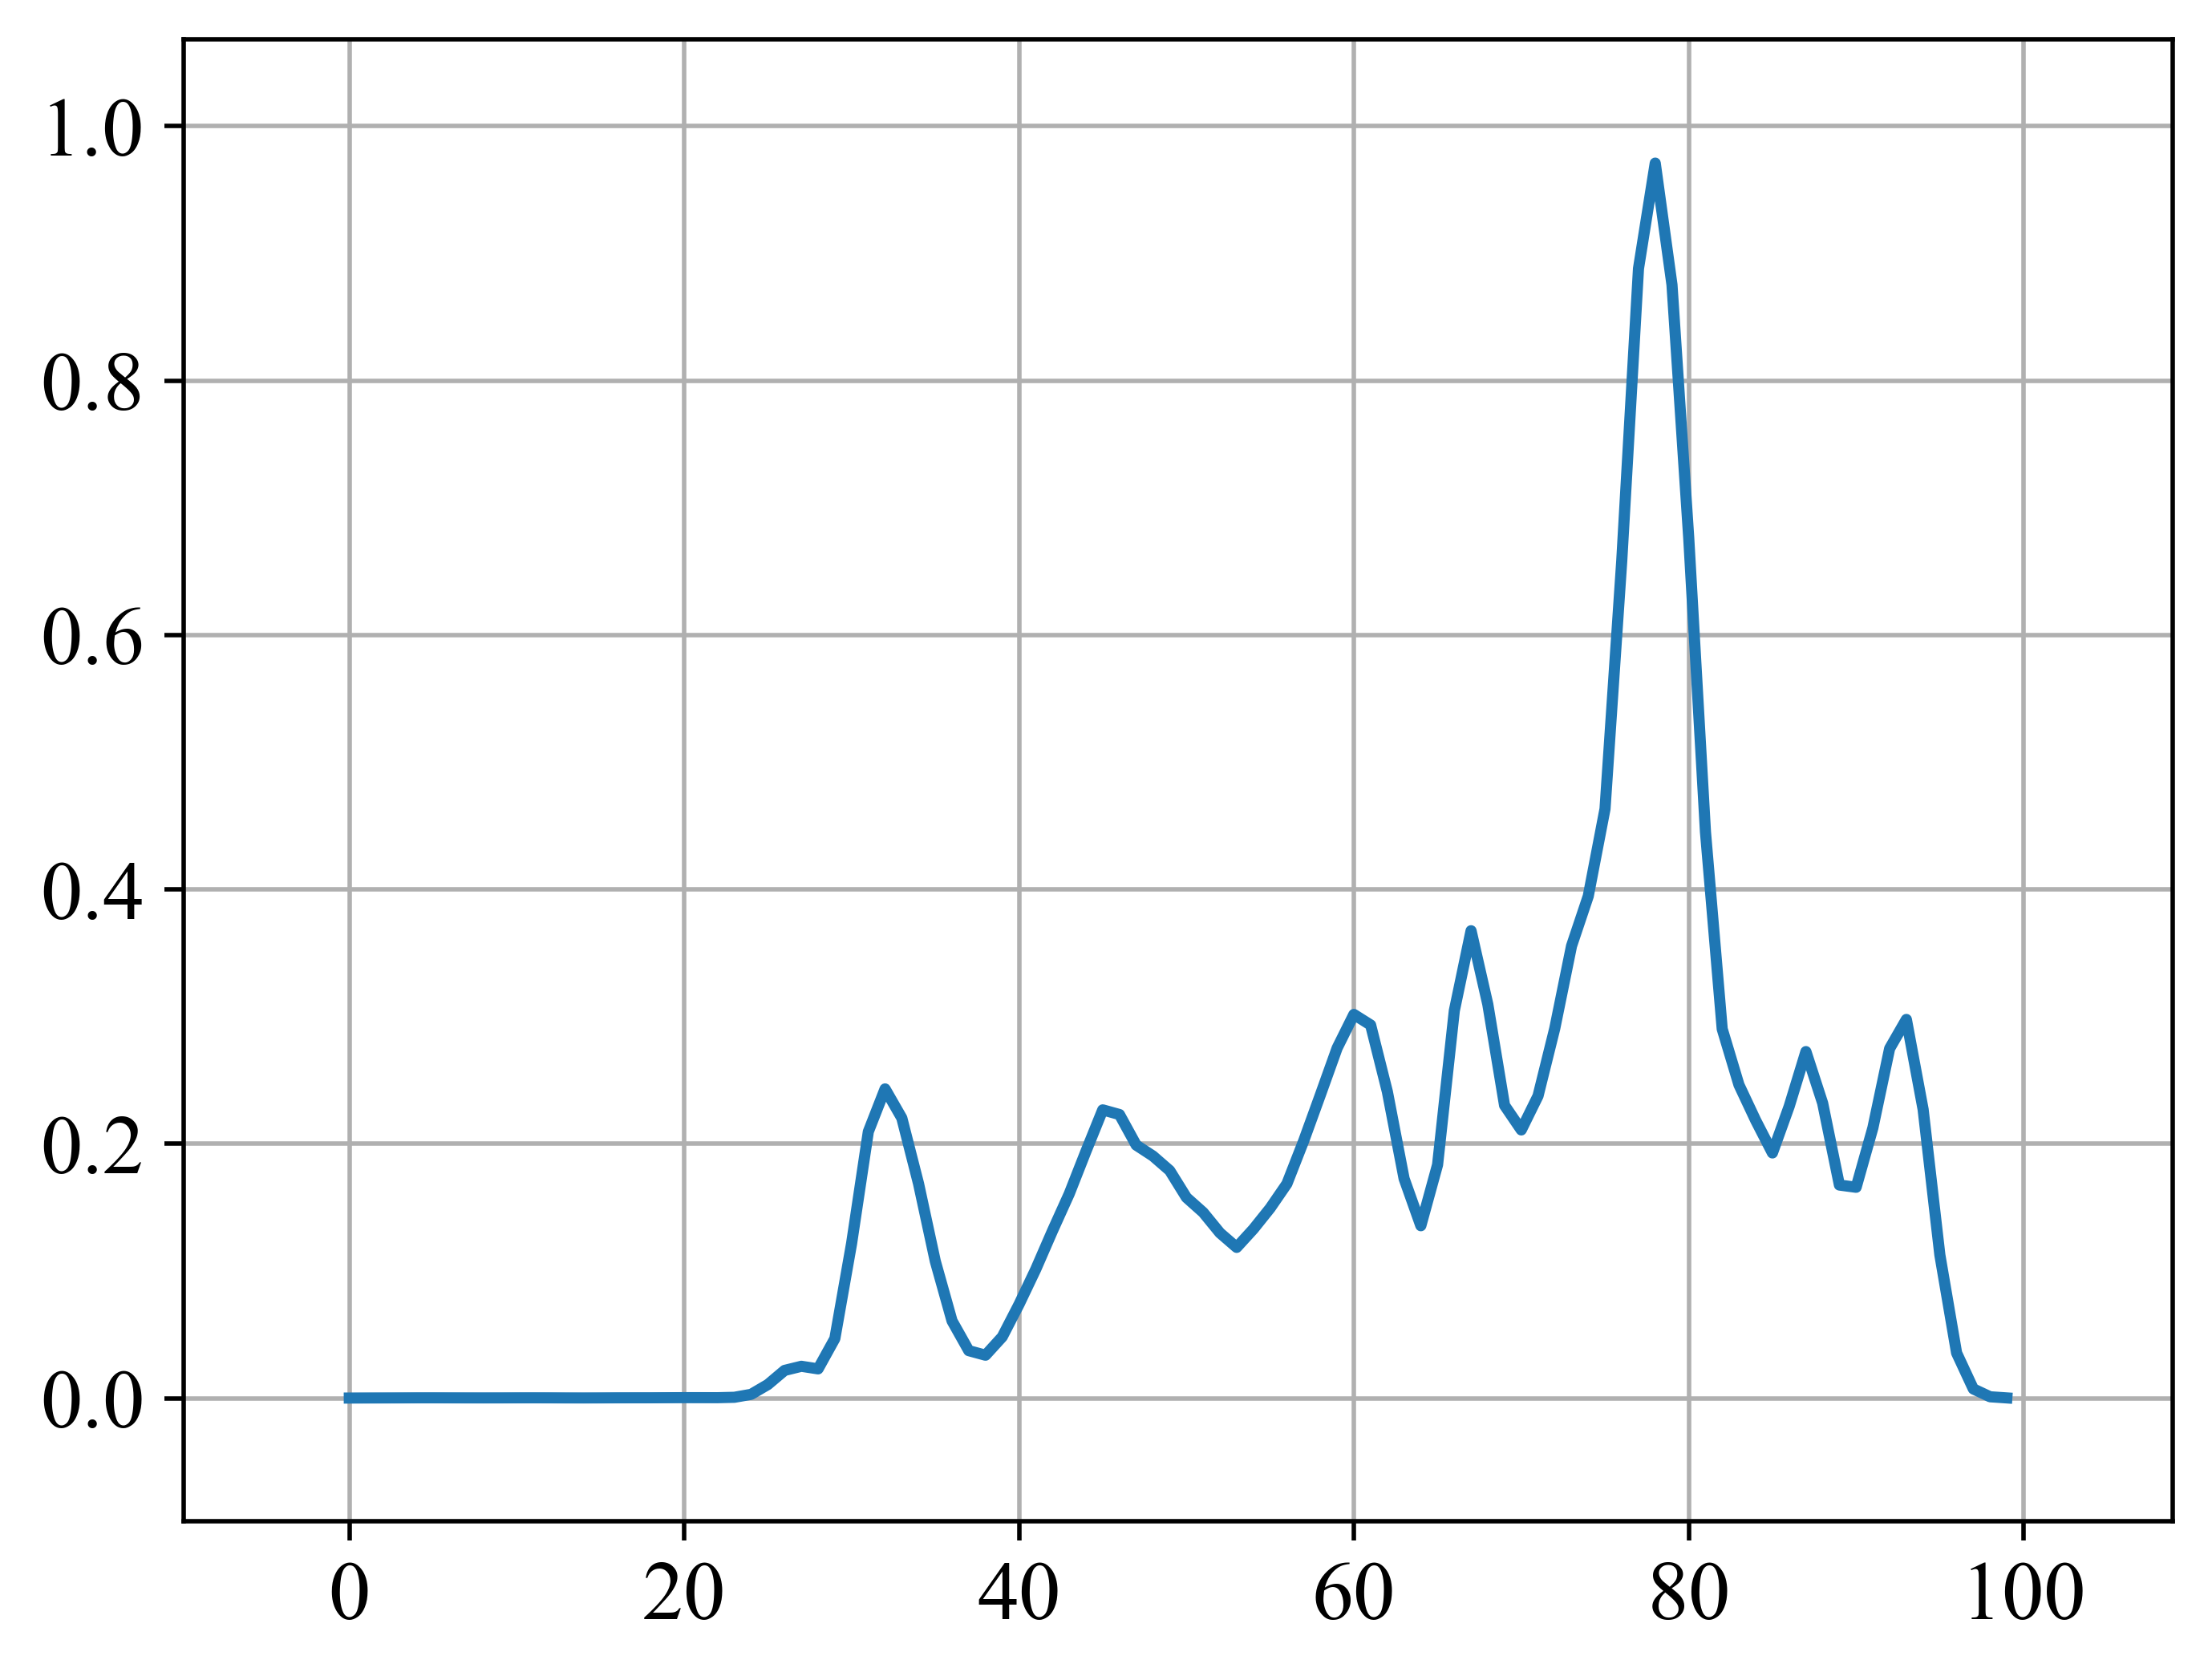

In [21]:
plt.plot(kernel(grid))

In [9]:
from sklearn.neighbors import KernelDensity
kde_emp = KernelDensity(bandwidth=5e-5)
emp_values = np.array([0.000618, 0.000425, 0.000597, 0.000528, 0.000393, 0.000721,
   0.000674, 0.000703, 0.000632, 0.000383, 0.000466, 0.000919,
   0.001419, 0.00063 , 0.000433, 0.000516, 0.001419, 0.000655,
   0.000674, 0.000676, 0.000694, 0.000396, 0.000688, 0.00061 ,
   0.000687, 0.000633, 0.000601, 0.00061 , 0.000747, 0.000356,
   0.000824, 0.000931, 0.000691, 0.000907, 0.000553, 0.000748,
   0.000828, 0.000907, 0.000457, 0.000494])
kde_emp = KernelDensity().fit(emp_values.reshape(-1, 1))

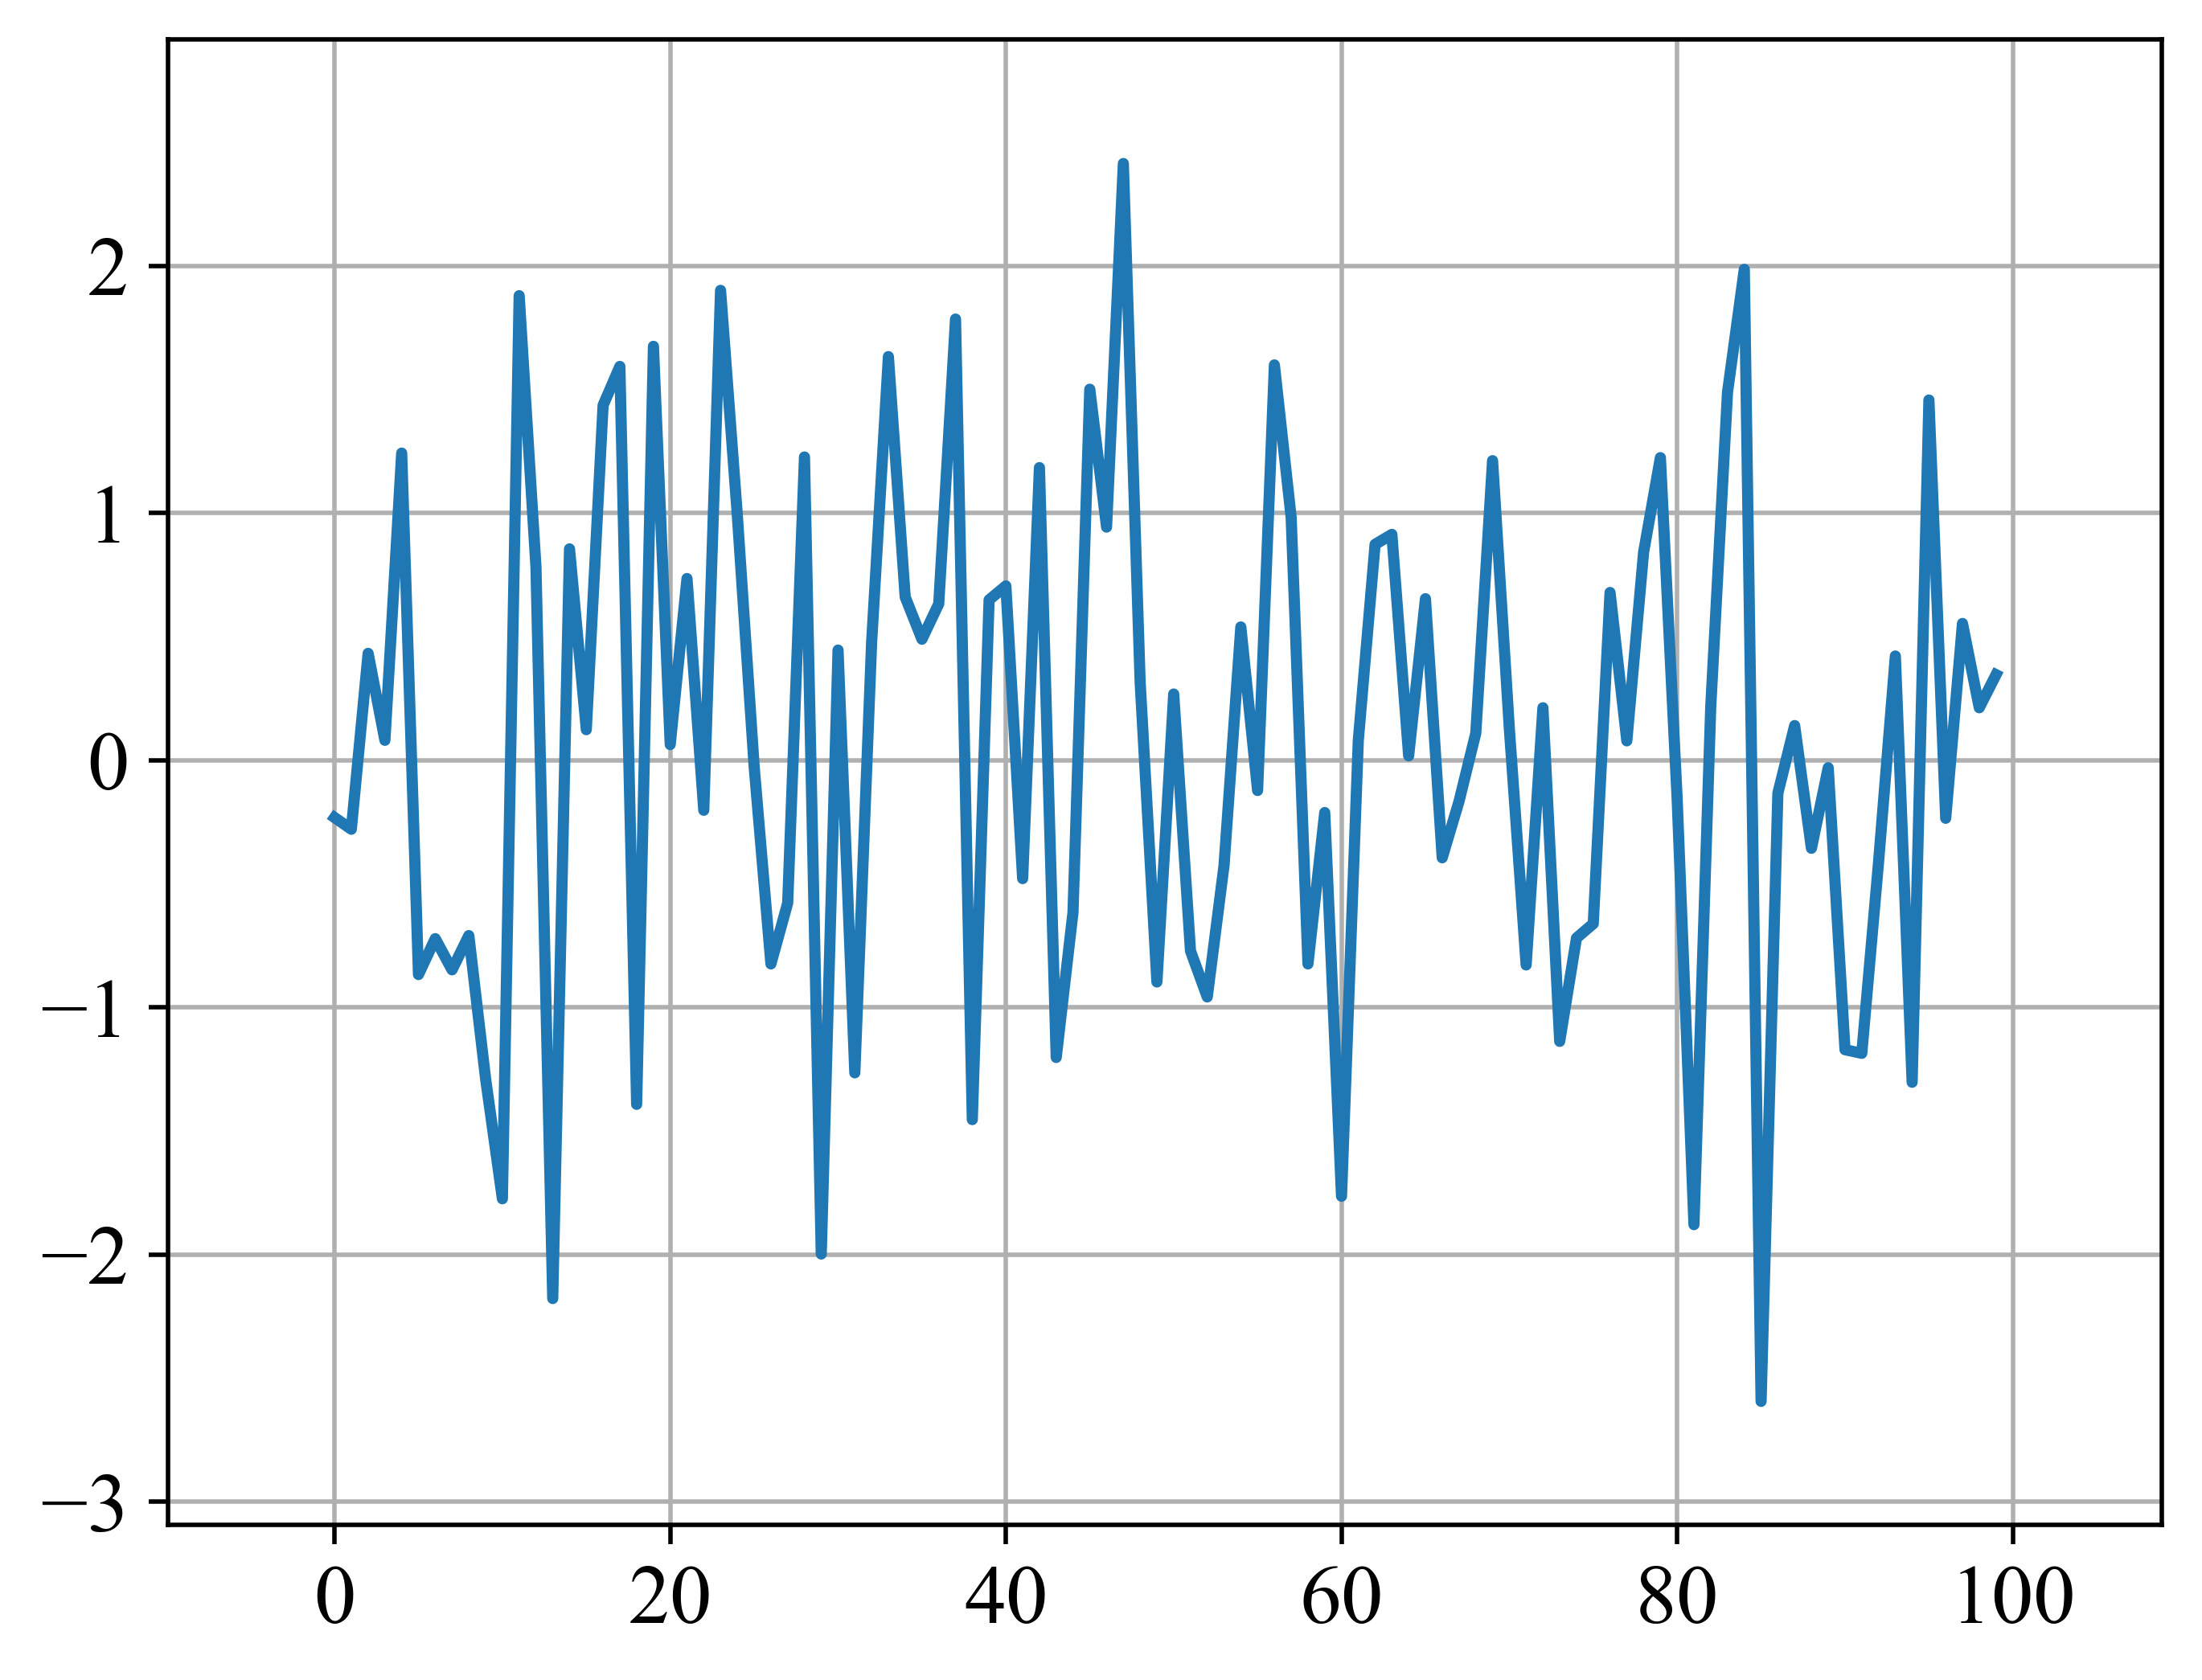

In [16]:
plt.plot(kde_emp.sample(100))

In [13]:

kde_emp(np.arange(-10, 0, 0.01))

TypeError: 'KernelDensity' object is not callable

In [ ]:
from sklearn.neighbors import KernelDensity
kde_emp = KernelDensity(bandwidth=5e-5)
kde_emp.fit(emp_values.reshape(-1, 1))

In [36]:
#!/usr/bin/env python
# Written by Greg Ver Steeg
# See readme.pdf for documentation
# Or go to http://www.isi.edu/~gregv/npeet.html

import warnings

import numpy as np
import numpy.linalg as la
from numpy import log
from scipy.special import digamma
from sklearn.neighbors import BallTree, KDTree

# CONTINUOUS ESTIMATORS


def entropy(x, k=3, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator
    x should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x = np.asarray(x)
    n_elements, n_features = x.shape
    x = add_noise(x)
    tree = build_tree(x)
    nn = query_neighbors(tree, x, k)
    const = digamma(n_elements) - digamma(k) + n_features * log(2)
    return (const + n_features * np.log(nn).mean()) / log(base)


def centropy(x, y, k=3, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator for the
    entropy of X conditioned on Y.
    """
    xy = np.c_[x, y]
    entropy_union_xy = entropy(xy, k=k, base=base)
    entropy_y = entropy(y, k=k, base=base)
    return entropy_union_xy - entropy_y


def tc(xs, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    entropy_features = [entropy(col, k=k, base=base) for col in xs_columns]
    return np.sum(entropy_features) - entropy(xs, k, base)


def ctc(xs, y, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropy(col, y, k=k, base=base) for col in xs_columns]
    return np.sum(centropy_features) - centropy(xs, y, k, base)


def corex(xs, ys, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    cmi_features = [mi(col, ys, k=k, base=base) for col in xs_columns]
    return np.sum(cmi_features) - mi(xs, ys, k=k, base=base)


def mi(x, y, z=None, k=3, base=2, alpha=0):
    """Mutual information of x and y (conditioned on z if z is not None)
    x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x)
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = (
            avgdigamma(x, dvec),
            avgdigamma(y, dvec),
            digamma(k),
            digamma(len(x)),
        )
        if alpha > 0:
            d += lnc_correction(tree, points, k, alpha)
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = (
            avgdigamma(xz, dvec),
            avgdigamma(yz, dvec),
            avgdigamma(z, dvec),
            digamma(k),
        )
    return (-a - b + c + d) / log(base)


def cmi(x, y, z, k=3, base=2):
    """Mutual information of x and y, conditioned on z
    Legacy function. Use mi(x, y, z) directly.
    """
    return mi(x, y, z=z, k=k, base=base)


def kldiv(x, xp, k=3, base=2):
    """KL Divergence between p and q for x~p(x), xp~q(x)
    x, xp should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert k < min(len(x), len(xp)), "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    x, xp = np.asarray(x), np.asarray(xp)
    x, xp = x.reshape(x.shape[0], -1), xp.reshape(xp.shape[0], -1)
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n - 1)
    tree = build_tree(x)
    treep = build_tree(xp)
    nn = query_neighbors(tree, x, k)
    nnp = query_neighbors(treep, x, k - 1)
    return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)


def lnc_correction(tree, points, k, alpha):
    e = 0
    n_sample = points.shape[0]
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point[None, :], k=k + 1, return_distance=False)[0]
        knn_points = points[knn]
        # Substract mean of k-nearest neighbor points
        knn_points = knn_points - knn_points[0]
        # Calculate covariance matrix of k-nearest neighbor points, obtain eigen vectors
        covr = knn_points.T @ knn_points / k
        _, v = la.eig(covr)
        # Calculate PCA-bounding box using eigen vectors
        V_rect = np.log(np.abs(knn_points @ v).max(axis=0)).sum()
        # Calculate the volume of original box
        log_knn_dist = np.log(np.abs(knn_points).max(axis=0)).sum()

        # Perform local non-uniformity checking and update correction term
        if V_rect < log_knn_dist + np.log(alpha):
            e += (log_knn_dist - V_rect) / n_sample
    return e


# DISCRETE ESTIMATORS
def entropyd(sx, base=2):
    """Discrete entropy estimator
    sx is a list of samples
    """
    unique, count = np.unique(sx, return_counts=True, axis=0)
    # Convert to float as otherwise integer division results in all 0 for proba.
    proba = count.astype(float) / len(sx)
    # Avoid 0 division; remove probabilities == 0.0 (removing them does not change the entropy estimate as 0 * log(1/0) = 0.
    proba = proba[proba > 0.0]
    return np.sum(proba * np.log(1.0 / proba)) / log(base)


def midd(x, y, base=2):
    """Discrete mutual information estimator
    Given a list of samples which can be any hashable object
    """
    assert len(x) == len(y), "Arrays should have same length"
    return entropyd(x, base) - centropyd(x, y, base)


def cmidd(x, y, z, base=2):
    """Discrete mutual information estimator
    Given a list of samples which can be any hashable object
    """
    assert len(x) == len(y) == len(z), "Arrays should have same length"
    xz = np.c_[x, z]
    yz = np.c_[y, z]
    xyz = np.c_[x, y, z]
    return (
        entropyd(xz, base)
        + entropyd(yz, base)
        - entropyd(xyz, base)
        - entropyd(z, base)
    )


def centropyd(x, y, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator for the
    entropy of X conditioned on Y.
    """
    xy = np.c_[x, y]
    return entropyd(xy, base) - entropyd(y, base)


def tcd(xs, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    entropy_features = [entropyd(col, base=base) for col in xs_columns]
    return np.sum(entropy_features) - entropyd(xs, base)


def ctcd(xs, y, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropyd(col, y, base=base) for col in xs_columns]
    return np.sum(centropy_features) - centropyd(xs, y, base)


def corexd(xs, ys, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    cmi_features = [midd(col, ys, base=base) for col in xs_columns]
    return np.sum(cmi_features) - midd(xs, ys, base)


# MIXED ESTIMATORS
def micd(x, y, k=3, base=2, warning=True):
    """If x is continuous and y is discrete, compute mutual information"""
    assert len(x) == len(y), "Arrays should have same length"
    entropy_x = entropy(x, k, base)

    y_unique, y_count = np.unique(y, return_counts=True, axis=0)
    y_proba = y_count / len(y)

    entropy_x_given_y = 0.0
    for yval, py in zip(y_unique, y_proba):
        x_given_y = x[(y == yval).all(axis=1)]
        if k <= len(x_given_y) - 1:
            entropy_x_given_y += py * entropy(x_given_y, k, base)
        else:
            if warning:
                warnings.warn(
                    "Warning, after conditioning, on y={yval} insufficient data. "
                    "Assuming maximal entropy in this case.".format(yval=yval)
                )
            entropy_x_given_y += py * entropy_x
    return abs(entropy_x - entropy_x_given_y)  # units already applied


def midc(x, y, k=3, base=2, warning=True):
    return micd(y, x, k, base, warning)


def centropycd(x, y, k=3, base=2, warning=True):
    return entropy(x, base) - micd(x, y, k, base, warning)


def centropydc(x, y, k=3, base=2, warning=True):
    return centropycd(y, x, k=k, base=base, warning=warning)


def ctcdc(xs, y, k=3, base=2, warning=True):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [
        centropydc(col, y, k=k, base=base, warning=warning) for col in xs_columns
    ]
    return np.sum(centropy_features) - centropydc(xs, y, k, base, warning)


def ctccd(xs, y, k=3, base=2, warning=True):
    return ctcdc(y, xs, k=k, base=base, warning=warning)


def corexcd(xs, ys, k=3, base=2, warning=True):
    return corexdc(ys, xs, k=k, base=base, warning=warning)


def corexdc(xs, ys, k=3, base=2, warning=True):
    return tcd(xs, base) - ctcdc(xs, ys, k, base, warning)


# UTILITY FUNCTIONS


def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)


def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]


def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)


def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))


def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric="chebyshev")
    return KDTree(points, metric="chebyshev")
